<a href="https://colab.research.google.com/github/MatheusRangelCardoso/tcc-bi-master-2019.1/blob/main/TCC_Energia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução:
Trabalho de conclusão de curso com o objetivo de constuir um modelo capaz de prever qual será o preço da energia na próxima hora.
<br>
<br>
O modelo utiliza como base de dados:
<br>
1 - Dados históricos do consumo de energia da Espanha
<br>
2 - Dados históricos de características climáticas presentes em cinco cidades da Espanha: Valencia, Madrid, Bilbao, Barcelona e Seville.
<br>
<br>
São criados três modelos utilizando a mesma arquitetura de rede neural (LSTM). A única diferença entre cada modelo é o número de variáveis utilizadas como input para realizar a previsão do consumo de energia.
<br>
<br>
O primeiro modelo possui 16 variáveis, o segundo modelo 10 variáveis e o terceiro modelo apresenta apenas o janelamento de uma única variável cinco horas atrás, possuindo assim seis variáveis.
<br>
<br>
O intuito da criação de três modelos com diferentes variáveis de input é verificar se o modelo construído pela rede neural é capaz de realizar previsões assertivas com a redução da complexidade do modelo, isto é, verificar se a medida que as variáveis de input são retiradas do modelo, a rede neural é capaz de melhorar suas previsões ou não.


# Importar Bibliotecas:

In [ ]:
# Importando Bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import drive
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

# Carregar dados Energia:

In [ ]:
drive.mount('/content/drive')
workdir_path = '/content/drive/My Drive/TCC' #Caminho para o workspace
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_energia = pd.read_csv("energy_dataset.csv",               #Carregar o Arquivo
                         parse_dates=["time"],               #Utilziar a coluna "time" como tipo "data/hora"
                         infer_datetime_format=True,)        #Inferir o o tipo de dados "data/hora" no dataframe
df_energia.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [ ]:
# Linhas e Colunas
df_energia.shape

(35064, 29)

## Verificar o tipo dos dados:

In [ ]:
# Tipo de dados
df_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

## Registros Duplicados:

In [ ]:
sum(df_energia.duplicated())

0

## Estatísticas Básicas:

In [ ]:
df_energia.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


**Conclusões:**
<br>
Colunas que só apresentam valor "0" ou nulo "NaN" deverão ser removidas. Visto que não poderão ser utilizadas para a construção do modelo pois elas não carregam em sí nenhuma informação.
<br>
<br>
Colunas:
<br>
1 - generation fossil coal-derived gas
<br>
2 - generation fossil oil shale
<br>
3 - generation fossil peat
<br>
4 - generation geothermal
<br>
5 - generation hydro pumped storage aggregated
<br>
6 - generation marine
<br>
7 - generation wind offshore
<br>
<br>
Colunas que contém a previsão de consumo um dia a frente não serão utilizadas para a construção do modelo.
<br>
<br>
Colunas:
<br>
8 - forecast solar day ahead
<br>
9 - forecast wind offshore eday ahead
<br>
10 - forecast wind onshore day ahead
<br>
11 - total load forecast

In [ ]:
df_energia = df_energia.drop(["generation fossil coal-derived gas",
                             "generation fossil oil shale",
                             "generation fossil peat",
                             "generation geothermal",
                             "generation hydro pumped storage aggregated",
                             "generation marine",
                             "generation wind offshore",
                             "forecast solar day ahead",
                             "forecast wind offshore eday ahead",
                             "forecast wind onshore day ahead",
                             "total load forecast"],
                             axis = 1)

df_energia.shape

(35064, 18)

## Registros Nulos
<br>
Lidando com regitros nulos em séries temporais:
<br>
<br>
Quando um registro nulo é encontrado em uma série temporal, não é recomendado substituir o valor pela média ou pela mediana. Pois isto poderia causar um viés nos dados visto que uma série temporal, os dados foram retirados em um intervalo de tempo pré determinado (no caso deste conjunto de dados, o intervalo ocorre de 1 em 1 hora). Desta forma substituir o valor pela média ou excluir completamente alinha é inviável. E excluir completamente a coluna também pois todas as variáveis apresentam um dado faltante.


In [ ]:
df_energia.isnull().sum()

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

**Conclusões:**
<br>
Há registros nulos nos dados. A base de dados contém 35064 registros e a coluna que contém maior registros nulos "total load actual" contém 36 registros nulos (cerca de 0,001% [36/35064] de registros). Desta maneira, será reaizada uma análisa para verificar o que fazer com os registros nulos.
<br>
<br>
A coluna "price actual" que é a "target variable" não apresenta nenhum registro nulo. O que é bom, pois evitaria a necessidade de excluir um registro do conjunto de dados (eliminando uma observação do intervalo de tempo do conjunto) ou evitaria a necessidade de uma criação de uma variável sintética para um determinado intervalo de tempo (o que poderia prejudicar a capacidade preditiva do modelo)


In [ ]:
df_energia[df_energia["total load actual"].isnull()]

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
108,2015-01-05 12:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.50,79.14
109,2015-01-05 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.80,73.95
110,2015-01-05 14:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.50,71.93
111,2015-01-05 15:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,71.50
112,2015-01-05 16:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,71.85
113,2015-01-05 17:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.60,80.53
661,2015-01-28 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.00,77.62
751,2015-02-01 07:00:00+01:00,449.0,312.0,4765.0,5269.0,222.0,480.0,980.0,1174.0,7101.0,44.0,75.0,48.0,208.0,3289.0,NaN,56.10,16.98
752,2015-02-01 08:00:00+01:00,453.0,312.0,4938.0,5652.0,288.0,0.0,1031.0,3229.0,7099.0,44.0,75.0,73.0,207.0,3102.0,NaN,57.69,19.56
753,2015-02-01 09:00:00+01:00,452.0,302.0,4997.0,5770.0,296.0,0.0,1083.0,4574.0,7097.0,43.0,71.0,809.0,204.0,2838.0,NaN,60.01,23.13


### Verificar o comportamento dos registros nulos.

Será avaliado o comportameto dos rgistros nulos resente na coluna "total load actual", pois esta coluna contém o maior número de registros nulos.
<br>
<br>
Será realizada uma analise em três intervalos:
<br>
1) do registro 0 ao registro 120
<br>
2) do registro 80 ao registro 120
<br>
3) do registro 650 ao 780

In [ ]:
# Do Registro 0 ao refistro 120
df_nulos_0 = df_energia [0:121]

# Do registro 80 ao registro 120
df_nulos_1 = df_energia[80:121]

# Do registro 650 ao registro 780
df_nulos_2 = df_energia[650:781]

### Realizar Interpolção

In [ ]:
#Criando uma cópia do dataframe
df_energia_interpolacao=df_energia

In [ ]:
# Realizando a interpolação na cópia acima
df_energia_interpolacao.interpolate(method='linear',
                                    limit_direction='forward',
                                    inplace=True,
                                    axis=0)

In [ ]:
# Segmentando o dtatrarama nos mesmos intervalos para realizar a comparação
df_int_0 = df_energia_interpolacao [0:121]
df_int_1 = df_energia_interpolacao[80:121]
df_int_2 = df_energia_interpolacao[650:781]

#### Comparando Interpolação de 0 a 120 registros

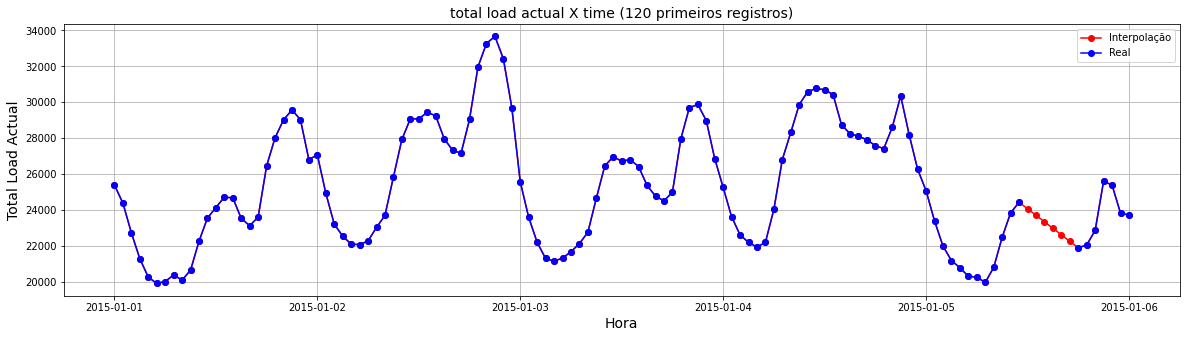

In [ ]:
fig = plt.figure(figsize=(20, 5))

#plt.subplot(2, 1, 1)
plt.plot(df_int_0['time'],df_int_0['total load actual'], color='red', marker='o')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)


#plt.subplot(2, 1, 2)
plt.plot(df_nulos_0['time'],df_nulos_0['total load actual'], color='blue', marker='o')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)

plt.xlabel('Hora')
plt.ylabel('Total Load Actual')
plt.legend(["Interpolação","Real"])
plt.title('total load actual X time (120 primeiros registros)', fontsize=14)

plt.show()

#### Comparando interpolação de 80 a 120 registros

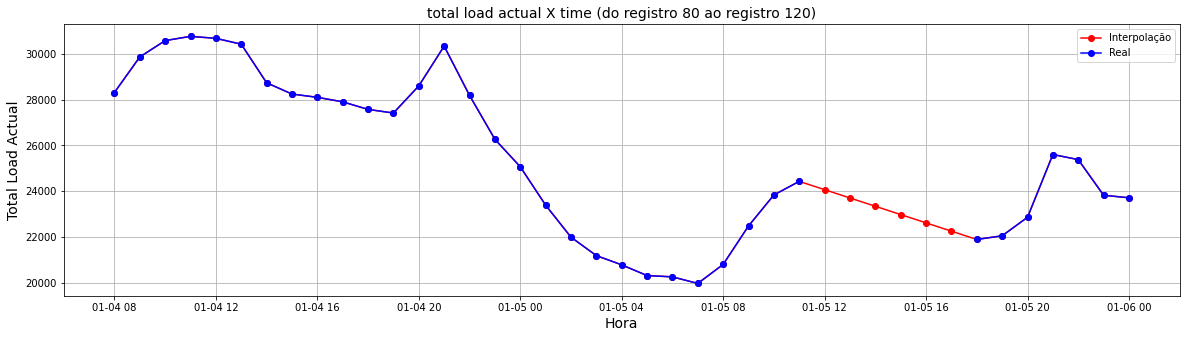

In [ ]:
fig = plt.figure(figsize=(20, 5))



#plt.subplot(2, 1, 1)
plt.plot(df_int_1['time'],df_int_1['total load actual'], color='red', marker='o')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)


#plt.subplot(2, 1, 2)
plt.plot(df_nulos_1['time'],df_nulos_1['total load actual'], color='blue', marker='o')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)

plt.xlabel('Hora')
plt.ylabel('Total Load Actual')
plt.legend(["Interpolação","Real"])
plt.title('total load actual X time (do registro 80 ao registro 120)', fontsize=14)

plt.show()

#### Comparando interpolação de 650 a 750 registro

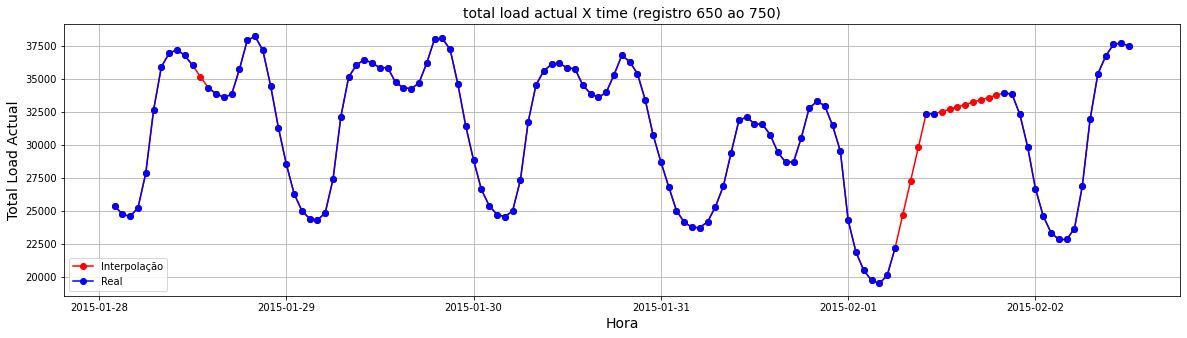

In [ ]:
fig = plt.figure(figsize=(20, 5))


#plt.subplot(2, 1, 1)
plt.plot(df_int_2['time'],df_int_2['total load actual'], color='red', marker='o')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)


#plt.subplot(2, 1, 2)
plt.plot(df_nulos_2['time'],df_nulos_2['total load actual'], color='blue', marker='o')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Total Load Actual', fontsize=14)
plt.grid(True)



plt.xlabel('Hora')
plt.ylabel('Total Load Actual')
plt.legend(["Interpolação","Real"])
plt.title('total load actual X time (registro 650 ao 750)', fontsize=14)

plt.show()

In [ ]:
#sobreescrevendo a base de dados de energia
df_energia=df_energia_interpolacao

# Carregar dados Clima

In [ ]:
df_clima = pd.read_csv("weather_features.csv")
df_clima.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


**Informações Dataframe:**
<br>
Dataframe contendo informações sobre o cima em 5 cidades distintas da Espanha: Valencia, Madrid, Bilbao, Barcelona, Seville
<br>
<br>
**Colunas:**
<br>
<br>
**dt_iso** = Coluna de "Timestamp" contendo a data e a hora do período observado
<br>
<br>
**city_name** = Nome de cada ciadade (Valencia, Madrid, Bilbao, Barcelona, Seville)
<br>
<br>
**temp** = Temperatura (Kelvin)
<br>
<br>
**temp_min** = Temperatura mínima (Kelvin)
<br>
<br>
**temp_max** = Temperatura máxima (Kelvin)
<br>
<br>
**pressure** = Pressão (hectopascal - hPa)
<br>
<br>
**humidity** = Umidade
<br>
<br>
**wind_speed** = Velocidade do Vento (m/s)
<br>
<br>
**wind_deg** = "Wind Degrees" (direção do vento)
<br>
<br>
**rain_1h** = mm de chuva em 1 hora
<br>
<br>
**rain_3h** = mm de chuva em 3 horas
<br>
<br>
**snow_3h** = precipitação de neve em 3 horas
<br>
<br>
**clouds_all** = Não encontrada informação no dicionário de dados
<br>
<br>
**weather_id** = Código do clima
<br>
<br>
**weather_main** = descrição simples do clima
<br>
<br>
**weather_description** = descrição detalhada do clima
<br>
<br>
**weather_icon** = ícone do clima (possivelmnete extraido do sistema)
<br>
<br>
**Observações:**
<br>
<br>
1) A coluna **weather_icon** pode ser descartada.
<br>
<br>
2) As colunas **weather_id**, **weather_main** e **weather_description**, aparentemente possuem a mesma informação.

## Descartando a coluna "weather_icon":

In [ ]:
df_clima = df_clima.drop(['weather_icon'], axis=1)
df_clima.head(1)

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear


## Anásie das colunas weather_id, weather_main e weather_description:

### weather_id
Contém uma numeração com o id do clima.

In [ ]:
df_clima['weather_id'].unique() #registros únicos na coluna weather_id

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 201, 211, 520, 300, 741, 301, 711, 302, 721, 310, 600, 616,
       615, 601, 210, 602, 611, 311, 612, 620, 531, 731, 761, 771])

In [ ]:
len(df_clima['weather_id'].unique()) # quantida de de registros únicos na coluna weather_id


38

### weather_main
Contém uma descrição simples do clima.

In [ ]:
df_clima['weather_main'].unique() #registros únicos na coluna weather_main

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [ ]:
len(df_clima['weather_main'].unique()) # quantida de de registros únicos na coluna weather_main

12

###weather_description
Contém uma descrição detalhada do clima.

In [ ]:
df_clima['weather_description'].unique() #registros únicos na coluna weather_description

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'thunderstorm with rain',
       'proximity thunderstorm', 'thunderstorm',
       'light intensity shower rain', 'light intensity drizzle', 'fog',
       'drizzle', 'smoke', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light intensity drizzle rain',
       'light snow', 'rain and snow', 'light rain and snow', 'snow',
       'light thunderstorm', 'heavy snow', 'sleet', 'rain and drizzle',
       'shower sleet', 'light shower sleet', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain',
       'sand dust whirls', 'proximity drizzle', 'dust', 'squalls'],
      dtype=object)

In [ ]:
len(df_clima['weather_description'].unique()) #registros únicos na coluna weather_description

43

**Conclusão**:
<br>
Retirar a coluna **"weather_main"** e **weather_description** pois elas representam uma descrição do clima em um determinado horario. Além disso, realziar o **"one-hot-concoding"** de 12 registros presentes na coluna **"weather_main"** e 43 registros na coluna **weather_description** vai poduzir 55 variáveis que poderiam prejudicar a capacidade preditiva do modelo.
<br>
<br>
Manter a coluna **weather_id** pois ela representa um código numérico de como estava o clima no determindado timestamp (produzindo menos informações do que a geração do one-hot-encoding das variaáveis **"weather_main"** e **weather_description**).

In [ ]:
df_clima = df_clima.drop(['weather_main'], axis=1) # removendo a coluna #weather_main
df_clima = df_clima.drop(['weather_description'], axis=1) # removendo a coluna weather_description
df_clima.shape

(178396, 14)

## Verificar o tipo dos dados:

In [ ]:
# Tipo de dados
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dt_iso      178396 non-null  object 
 1   city_name   178396 non-null  object 
 2   temp        178396 non-null  float64
 3   temp_min    178396 non-null  float64
 4   temp_max    178396 non-null  float64
 5   pressure    178396 non-null  int64  
 6   humidity    178396 non-null  int64  
 7   wind_speed  178396 non-null  int64  
 8   wind_deg    178396 non-null  int64  
 9   rain_1h     178396 non-null  float64
 10  rain_3h     178396 non-null  float64
 11  snow_3h     178396 non-null  float64
 12  clouds_all  178396 non-null  int64  
 13  weather_id  178396 non-null  int64  
dtypes: float64(6), int64(6), object(2)
memory usage: 19.1+ MB


### Mudar o tipo dos dados:
Mudar o tipo dos dados de int64 (número inteiro) para float64 (número decimal)

In [ ]:
# Mudar o tipo das colunas do dataframe de int64 para float64
colunas = df_clima.select_dtypes(include=[np.int64]).columns #Seleciona as colunas que são do tipo int64

for coluna in colunas:
  df_clima[coluna] = df_clima[coluna].values.astype(np.float64) # Loop que converte a ista de colunas a cima de int64 para float 64

df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dt_iso      178396 non-null  object 
 1   city_name   178396 non-null  object 
 2   temp        178396 non-null  float64
 3   temp_min    178396 non-null  float64
 4   temp_max    178396 non-null  float64
 5   pressure    178396 non-null  float64
 6   humidity    178396 non-null  float64
 7   wind_speed  178396 non-null  float64
 8   wind_deg    178396 non-null  float64
 9   rain_1h     178396 non-null  float64
 10  rain_3h     178396 non-null  float64
 11  snow_3h     178396 non-null  float64
 12  clouds_all  178396 non-null  float64
 13  weather_id  178396 non-null  float64
dtypes: float64(12), object(2)
memory usage: 19.1+ MB


## Verificar Duplicados:

In [ ]:
sum(df_clima.duplicated())

21

In [ ]:
df_valencia = df_clima[df_clima['city_name']=="Valencia"] # Seleciona só os registros com o valor de "Valencia" na coluna 'city_name'
df_valencia_duplicado = df_valencia[df_valencia.duplicated()] # Selecioan somente os valores duplicados do dataframe acima
df_valencia_duplicado

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
125,2015-01-06 04:00:00+01:00,Valencia,273.142,273.142,273.142,995.0,86.0,1.0,265.0,0.0,0.0,0.0,0.0,800.0
6566,2015-10-01 02:00:00+02:00,Valencia,289.740,286.480,292.040,1021.0,88.0,0.0,0.0,0.0,0.0,0.0,40.0,802.0
15345,2016-09-30 02:00:00+02:00,Valencia,288.060,285.370,291.250,1021.0,86.0,1.0,45.0,0.0,0.0,0.0,0.0,800.0
24135,2017-09-30 02:00:00+02:00,Valencia,292.150,292.150,292.150,1021.0,82.0,0.0,0.0,0.0,0.0,0.0,20.0,801.0
32900,2018-09-30 02:00:00+02:00,Valencia,292.150,292.150,292.150,1017.0,82.0,2.0,320.0,0.0,0.0,0.0,0.0,800.0


Aparentemente os valores duplicados são colunas que contém o mesmo valor. Como existem 5 cidades distintas e que as observações são realizadas de hora em hora, será necessário garantir que **não existe um registro duplicado, ou seja, um registro contendo um valor duplicado para uma mesma cidade em um mesmo horário.**
<br>
<br>
O método **".duplicated()"** está mostrando somente os registros duplicados em relação aos valores. Para verificar se existe um valor duplicado para uma mesma cidade em um mesmo horário, será necessário definir a coluna **"dt_iso"** como a coluna de índice do dataframe (garantir que não existe horários repetiods), depois agrupar os registros por cidade e depois comparar a quantidade desses registros com o "df_energia"
<br>
<br>
Primeiramente, para avaliar registros duplicados, vamos transformar a coluna "dt_iso", que contem o tempo de observação no índice do dataframe:

In [ ]:
df_clima['time'] = pd.to_datetime(df_clima['dt_iso'], utc=True, infer_datetime_format=True) #Cria uma coluna "time" com a informação da coluna "dt_iso" no formato de timestamp
df_clima = df_clima.drop(['dt_iso'], axis=1) # apaga a coluna "dt_iso" do dataframe (ela não é mais necessária)
df_clima = df_clima.set_index('time') #tranforma a coluna "time" para o indice do dataframe
df_clima.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
time,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0


Será necessário agrupar, (utilziando o método **".groupby()"** o dataframe por cidade e ver se os registros batem com a quantidade de registros presentes na base de dados de energia (**"df_energia"**).
<br>
<br>
Ou seja, a quantidade de registros da base de dados de energia deverá ser a mesma quantidade  presente em cada cidade separadamente, caso a quantidade de registros presentes em cada cidade individualmente seja maior do que a quantidade de registros presentes no "df_energia", isto indica registros duplicados.

In [ ]:
print('Registros "df_energia": {}\n'.format(df_energia.shape[0])) # printa  aquantidade de registros na base de dados "df_energia"

cidades = df_clima['city_name'].unique() # cria uma lista com o nome das 5 cidades tendo como base "df_clima"
clima_groupby = df_clima.groupby('city_name') # agrupa os registros do "df_clima" por cidade

for cidade in cidades:
    print('Cidade: {}\n'.format(cidade), #printa o  nome da cidade em que estamos realziando a coontafgem de registro,
          '  Registros: {}\n'.format(clima_groupby.get_group('{}'.format(cidade)).shape[0]), #Printa a quantidade de registrospresente na base "cila_groupby" [lembando que é uma base de dados agrupada por cidade então vai printar o número de registros por cidade]
          '  Há possíveis registros duplicados? {}\n'.format(not df_energia.shape[0]==clima_groupby.get_group('{}'.format(cidade)).shape[0]), # compara para ver se a quantidade  de registros presentes no "df_energia" é igual a quantidade  de registros presentes por cidade. Se for igual, ele rotorna "False", ou seja, não há registros duplicados, se for diferente ele reforna "True", ou seja, há possíbeus registros duplicados, ou seja, euma mesma cidade em um mesmo horário apresenta valores duplicados
          '  Análise Válida? {}\n'.format(df_energia.shape[0]<=clima_groupby.get_group('{}'.format(cidade)).shape[0])) # Ferifica se os registros das cidades são menores do que a quantidade de registros no "df_energia" se for menor, indica que há menos registros para essa cidade do que no número de observações em "df_energia", o que invalidaria completamente esta análise...


Registros "df_energia": 35064

Cidade: Valencia
   Registros: 35145
   Há possíveis registros duplicados? True
   Análise Válida? True

Cidade: Madrid
   Registros: 36267
   Há possíveis registros duplicados? True
   Análise Válida? True

Cidade: Bilbao
   Registros: 35951
   Há possíveis registros duplicados? True
   Análise Válida? True

Cidade:  Barcelona
   Registros: 35476
   Há possíveis registros duplicados? True
   Análise Válida? True

Cidade: Seville
   Registros: 35557
   Há possíveis registros duplicados? True
   Análise Válida? True



**Análise:**
<br>
Para todas as cidades, a quantidade de registros é maior do que a quantidade presente no "df_energia", o que indica que pode haver registros duplicados em todas as cidades.
<br>
<br>
Para eliminar as duplicadas, será necessário resetar o índice do dataframe, eliminar as duplicadas (deixando somente o primeiro registro para a **chave composta "time"** e **"city_name"**) e colocar a coluna "time" como índice novamente.

In [ ]:
df_clima = df_clima.reset_index().drop_duplicates(subset=['time','city_name'], keep='first').set_index('time') # Resetar o índice, remover duplicadas pela chave composta "time" e "city name", deixar o índice como "time"
df_clima.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
time,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0


## Validando duplicadas novamente:

In [ ]:
print('Registros "df_energia": {}\n'.format(df_energia.shape[0])) # printa  aquantidade de registros na base de dados "df_energia"

cidades = df_clima['city_name'].unique() # cria uma lista com o nome das 5 cidades tendo como base "df_clima"
clima_groupby = df_clima.groupby('city_name') # agrupa os registros do "df_clima" por cidade

for cidade in cidades:
    print('Cidade: {}\n'.format(cidade), #printa o  nome da cidade em que estamos realziando a coontafgem de registro,
          '  Registros: {}\n'.format(clima_groupby.get_group('{}'.format(cidade)).shape[0]), #Printa a quantidade de registrospresente na base "cila_groupby" [lembando que é uma base de dados agrupada por cidade então vai printar o número de registros por cidade]
          '  Há possíveis registros duplicados? {}\n'.format(not df_energia.shape[0]==clima_groupby.get_group('{}'.format(cidade)).shape[0]), # compara para ver se a quantidade  de registros presentes no "df_energia" é igual a quantidade  de registros presentes por cidade. Se for igual, ele rotorna "False", ou seja, não há registros duplicados, se for diferente ele reforna "True", ou seja, há possíbeus registros duplicados, ou seja, euma mesma cidade em um mesmo horário apresenta valores duplicados
          '  Análise Válida? {}\n'.format(df_energia.shape[0]<=clima_groupby.get_group('{}'.format(cidade)).shape[0])) # Ferifica se os registros das cidades são menores do que a quantidade de registros no "df_energia" se for menor, indica que há menos registros para essa cidade do que no número de observações em "df_energia", o que invalidaria completamente esta análise...


Registros "df_energia": 35064

Cidade: Valencia
   Registros: 35064
   Há possíveis registros duplicados? False
   Análise Válida? True

Cidade: Madrid
   Registros: 35064
   Há possíveis registros duplicados? False
   Análise Válida? True

Cidade: Bilbao
   Registros: 35064
   Há possíveis registros duplicados? False
   Análise Válida? True

Cidade:  Barcelona
   Registros: 35064
   Há possíveis registros duplicados? False
   Análise Válida? True

Cidade: Seville
   Registros: 35064
   Há possíveis registros duplicados? False
   Análise Válida? True



**Observação:**
<br>
O problema de registros duplicados foi solucionado.

## Estatísticas Básicas:

In [ ]:
df_clima.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,175320.000000,175320.000000,175320.000000,1.753200e+05,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000
mean,289.707651,288.428433,291.172255,1.070199e+03,68.032307,2.470009,166.724909,0.069308,0.000386,0.004846,24.344057,763.452390
std,8.024910,7.948249,8.613916,6.021769e+03,21.838097,2.095140,116.548788,0.385915,0.007348,0.224547,30.339522,103.125539
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.830000,282.784586,284.909258,1.013000e+03,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,178.000000,0.000000,0.000000,0.000000,16.000000,800.000000
75%,295.240000,294.150000,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


**Observação:**
<br>
A coluana "rain_3h" mostra a quantidade de chuva em milimetros que caiu em um período de 3 horas, a coluna "rain_1h" mostra a mesma informação em um período de 1 hora... (as informações são redundantes a quantidade de chuva, em milímetros, observada durante o período de 1 hora está contido dentro do período de 3 horas)
<br>
<br>
Desta maneira, média de rain_3h deveria ser maior ou iagual do que rain_1h pois a quantidade de chuva observada durante o período de 1 hora está contido dentro do período de 3 horas.
<br>
<br>
Essas vairáveis serão analisadas postriormente para verificar se elas serão utilziadas na construção do modelo ou não.


## Registros Nulos:

In [ ]:
df_clima.isnull().sum()

city_name     0
temp          0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
weather_id    0
dtype: int64

# Juntando os dataframes:

Ajustando o texto de **Barcelona**. Barcelona está com um espaço antes e será ajustado de **" Barcelona"** para **"Barcelona"**.

In [ ]:
# Ajustando texto de "Barcelona"
df_clima['city_name'] = df_clima['city_name'].str.replace(" Barcelona","Barcelona")

### Ajustando a coluna Time
A coluna "time" não foi formatada para o tipo de data corretamente.
<br>
Será necessário realizar a conversão com o trecho de código abaixo:

In [ ]:
# A coluna "time" não foi formatada para o tipo de data corretamente.
# Será necessário realizar a conversão com o trecho de código abaixo
df_energia['time'] = pd.to_datetime(df_energia['time'],
                                    utc=True,
                                    infer_datetime_format=True)

df_energia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35064 non-null  float64            
 2   generation fossil brown coal/lignite         35064 non-null  float64            
 3   generation fossil gas                        35064 non-null  float64            
 4   generation fossil hard coal                  35064 non-null  float64            
 5   generation fossil oil                        35064 non-null  float64            
 6   generation hydro pumped storage consumption  35064 non-null  float64            
 7   generation hydro run-of-river and poundage   35064 non-null  float64            
 8   generation hydro water res

Criando um dataframe para cada cidade

In [ ]:
df_valencia = df_clima[df_clima['city_name']=="Valencia"]
df_madrid = df_clima[df_clima['city_name']=="Madrid"]
df_bilbao = df_clima[df_clima['city_name']=="Bilbao"]
df_barcelona = df_clima[df_clima['city_name']=="Barcelona"]
df_seville = df_clima[df_clima['city_name']=="Seville"]

In [ ]:
# faz uma cópia do df energia em uma variável chamada df_final'
df_final = df_energia

# Colocando os dataframes em uma lista para a realização do "Merge":
dfs_merge = [df_valencia, df_madrid, df_bilbao, df_barcelona, df_seville]

for df in dfs_merge:
    # coloca um sufixo no nome de cada coluna de cada cidade (armazena o nome da respectiva cidade presente nos dataframes nesta variável. Observação, o texto vem excrito ['Seville'] então a string foi manipulada para remover ops caracteres indesejáveis: ' ; [ ; ])
    texto_cidade = str(df['city_name'].unique()).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    # Adiciona um "sufixo" em todas as colunas do dataframe com o texto da cidade acima. Por exemplo: coluna original: "city_name" coluna com o sufixo: "city_name_Seville", desta maneira será possível identificar os dados referentes a cada cidade após a realização do merge
    df = df.add_suffix('_{}'.format(texto_cidade))
    # realzia o merge dos dataframes de cada  cidade com o df energia
    df_final = df_final.merge(df, on=['time'], how='outer')
    # remove nome das colunas com city_name_nome da cidade:
    df_final = df_final.drop('city_name_{}'.format(texto_cidade), axis=1) # retira a coluna "city_name" com o respectivo sufixo do nome da cidade (não é uma coluna que agrega informação)
    


df_final

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_id_Valencia,temp_Madrid,temp_min_Madrid,temp_max_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,rain_3h_Madrid,snow_3h_Madrid,clouds_all_Madrid,weather_id_Madrid,temp_Bilbao,temp_min_Bilbao,temp_max_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,rain_3h_Bilbao,snow_3h_Bilbao,clouds_all_Bilbao,weather_id_Bilbao,temp_Barcelona,temp_min_Barcelona,temp_max_Barcelona,pressure_Barcelona,humidity_Barcelona,wind_speed_Barcelona,wind_deg_Barcelona,rain_1h_Barcelona,rain_3h_Barcelona,snow_3h_Barcelona,clouds_all_Barcelona,weather_id_Barcelona,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,rain_3h_Seville,snow_3h_Seville,clouds_all_Seville,weather_id_Seville
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,800.0,269.657312,269.657312,269.657312,1036.0,97.0,0.0,226.0,0.0,0.0,0.0,0.0,800.0,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,800.0,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,800.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,267.325,267.325,267.325,971.0,63.0,1.0,309.0,0.0,0.0,0.0,0.0,800.0,269.763500,269.763500,269.763500,1035.0,97.0,0.0,229.0,0.0,0.0,0.0,0.0,800.0,281.625,281.625,281.625,1035.0,100.0,7.0,58.0,0.0,0.0,0.0,0.0,800.0,273.375,273.375,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,800.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,800.0,269.251688,269.251688,269.251688,1036.0,97.0,1.0,224.0,0.0,0.0,0.0,0.0,800.0,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,800.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,800.0,269.203344,269.203344,269.203344,1035.0,97.0,1.0,225.0,0.0,0.0,0.0,0.0,800.0,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,800.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,266.186,266.186,266.186,971.0,64.0,1.0,273.0,0.0,0.0,0.0,0.0,800.0,269.485500,269.485500,269.485500,1035.0,97.0,1.0,221.0,0.0,0.0,0.0,0.0,800.0,281.286,281.286,281.286,1036.0,100.0,7.0,48.0,0.0,0.0,0.0,0.0,800.0,274.086,274.086,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
df_final.shape

(35064, 78)

# Escolha de Variáveis

## rain_1h e rain_3h:
rain_1h = quantidade de chuva em millimetros durante 1h
<br>
<br>
rain_3h = quantidade de chuva em milímetros durante 3h
<br>
<br>
Blase clima **"rain_3h"** e **"rain_1h"** as informaçeõs são **"redundantes"** a quantidade de chuva em milímetros durante 3 horas já está englobando a quantidade de chuva em milímetros duarante 1 hora. Pórem, como observado anteriormente, a média de chuva de **"rain_3h"** é menor do que **"rain_1h"**. Se **"rain_1h"** está contida dentro de **"rain_3h"**, era esperado da média de **"rain_3h"** ser maior ou igual a média de **"rain_1h"**.
<br>
<br>
Será apresentado gráficos com as colunas rain_1h e rain_3h para todas as cidades para uma análise dos dados destas variaáveis.

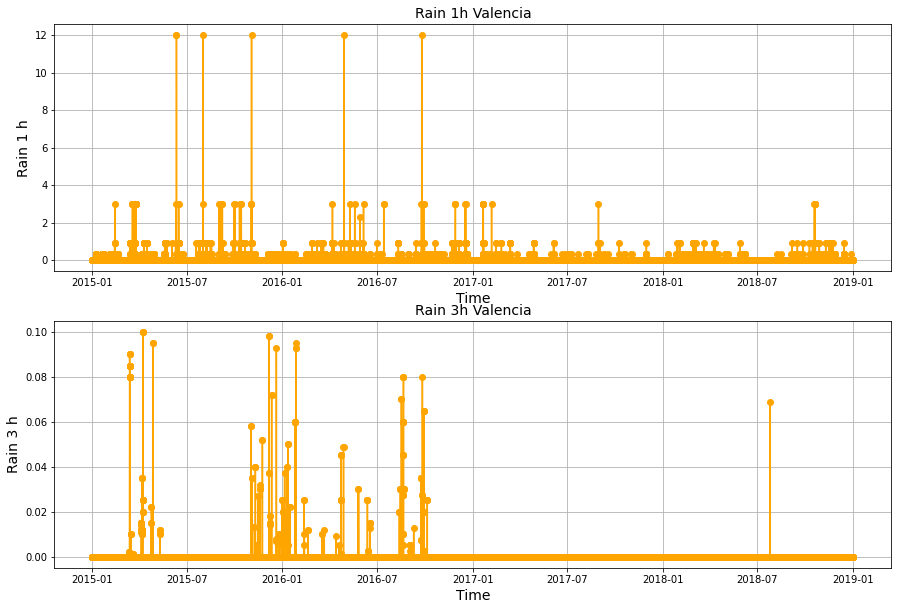

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_final['time'],df_final['rain_1h_Valencia'], color='orange', marker='o')
plt.title('Rain 1h Valencia', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 1 h', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_final['time'],df_final['rain_3h_Valencia'], color='orange', marker='o')
plt.title('Rain 3h Valencia', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 3 h', fontsize=14)
plt.grid(True)

plt.show()

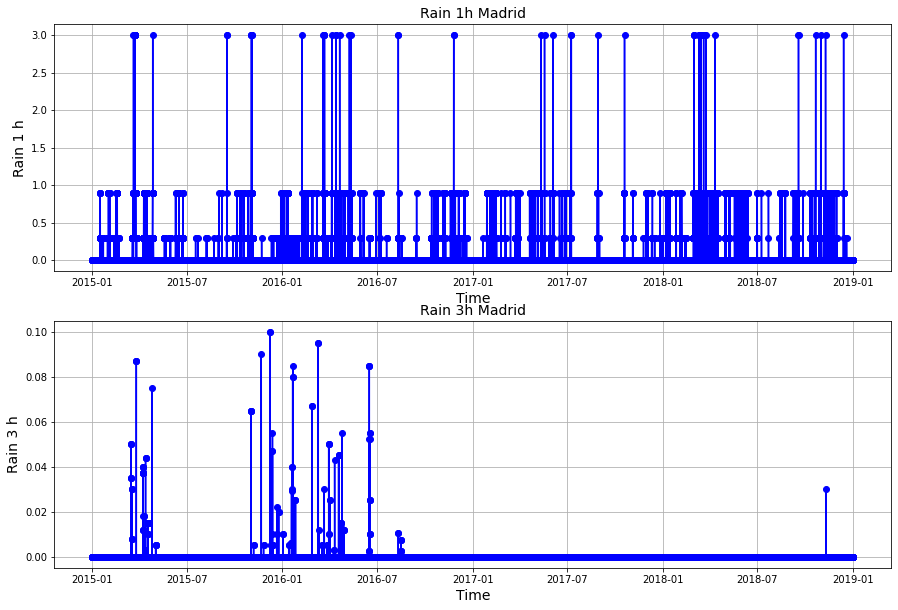

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_final['time'],df_final['rain_1h_Madrid'], color='blue', marker='o')
plt.title('Rain 1h Madrid', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 1 h', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_final['time'],df_final['rain_3h_Madrid'], color='blue', marker='o')
plt.title('Rain 3h Madrid', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 3 h', fontsize=14)
plt.grid(True)

plt.show()

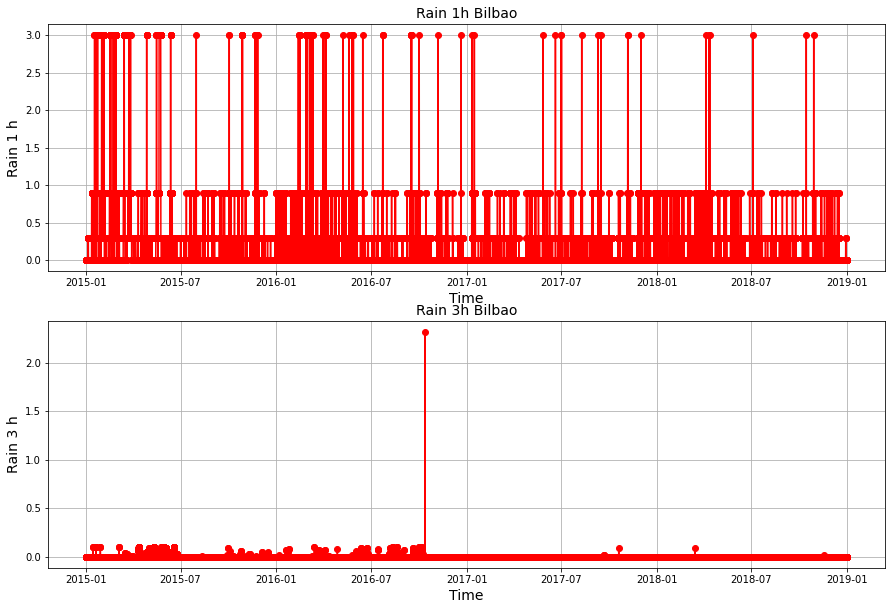

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_final['time'],df_final['rain_1h_Bilbao'], color='red', marker='o')
plt.title('Rain 1h Bilbao', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 1 h', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_final['time'],df_final['rain_3h_Bilbao'], color='red', marker='o')
plt.title('Rain 3h Bilbao', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 3 h', fontsize=14)
plt.grid(True)

plt.show()

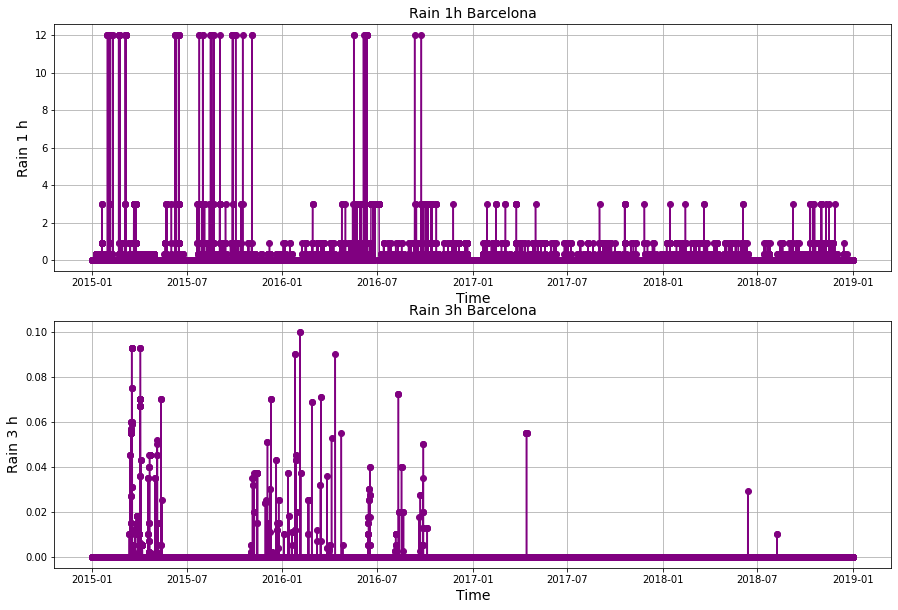

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_final['time'],df_final['rain_1h_Barcelona'], color='purple', marker='o')
plt.title('Rain 1h Barcelona', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 1 h', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_final['time'],df_final['rain_3h_Barcelona'], color='purple', marker='o')
plt.title('Rain 3h Barcelona', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 3 h', fontsize=14)
plt.grid(True)

plt.show()

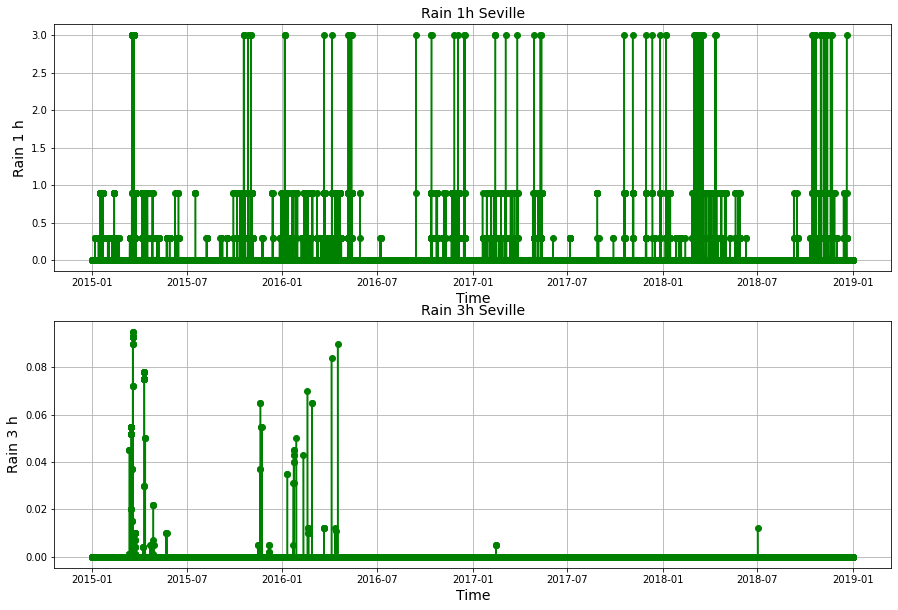

In [ ]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(df_final['time'],df_final['rain_1h_Seville'], color='g', marker='o')
plt.title('Rain 1h Seville', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 1 h', fontsize=14)
plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(df_final['time'],df_final['rain_3h_Seville'], color='g', marker='o')
plt.title('Rain 3h Seville', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rain 3 h', fontsize=14)
plt.grid(True)

plt.show()

**Conclusão:**
<br>
Ao observar os pontos nos gráficos acima, constata-se que a variável **"rain_3h"**, apresenta grande quantidade de registros igual a **"0"**, enquanto para um mesmo intervalo de tempo, a variável **"rain_1h"** apresenta um valor diferente de **"0"**.
<br>
<br>
Este é um dos motivos para a média de **"rain_1h"** estar maior do que **"rain_3h"**. Desta maneira, como a coluna **"rain_3h"** apresenta uma grande quantidade de registros igual a **"0"**, esta variável será eliminada da base de dados final.


In [ ]:
df_final = df_final.drop(['rain_3h_Valencia',
                          'rain_3h_Madrid',
                          'rain_3h_Bilbao',
                          'rain_3h_Barcelona',
                          'rain_3h_Seville'],
                         axis=1)
df_final.shape

(35064, 73)

##Correlação
Medido o coeficiente de correlação de **Pearson**.
<br>
<br>
Onde:
<br>
<br>
**Correlação = 1:**
<br>
Significa uma correlação perfeita e positiva entre a variável preditiva e a variável alvo. Ou seja, quando a variaável preditiva observada aumentar 1 unidade, a variável alvo almenta 1 unidade.
<br>
<br>
**Correlação = -1:**
<br>
Significa uma correlação perfeita e negativa entre a variável preditiva e a variável alvo. Ou seja, quando a variaável preditiva observada aumentar 1 unidade, a variável alvo diminuiu 1 unidade.
<br>
<br>
**Correlação = 0:**
<br>
Significa que não existe uma correlação linear entre as duas variáveis observadas.

In [ ]:
# Printando correlação das variáveis preditivas em relação a variável alvo (price actual): 
correlacao = df_final.corr(method='pearson')
print(correlacao['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0.096279
temp_Valencia                                  0.090505
pressure_Seville                               0

**Observação:**
<br>
As variáveis **"snow_3h_Barcelona"** e **"snow_eh_Seville"** não apresentam nenhum tipo de correlação linear com a variável alvo (**"price atual"**), portato serão removidas.

In [ ]:
# Removendo as colunas 'snow_3h_Barcelona'e 'snow_3h_Seville':
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)
df_final.shape

(35064, 71)

### Filtro estatístico:
Selecionar as 16 primeiras variáveis mais correlacionadas com a variável alvo.

In [ ]:
# Transformando todo os números negativos em positivos e pritando os 17 primeiros registros
correlacao_price_actual = abs(correlacao['price actual'])
print(correlacao_price_actual.sort_values(ascending=False)[0:17].to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation hydro pumped storage consumption    0.426196
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
wind_speed_Madrid                              0.245861
generation wind onshore                        0.220497
pressure_Bilbao                                0.194063
generation waste                               0.168710
wind_speed_Bilbao                              0.143327
generation biomass                             0.142671
wind_speed_Barcelona                           0.138658
wind_deg_Seville                               0.137099


## Janelamento:
Realizar o janelamento de todas das 16 variáveis selecionadas acoma até 5 horas atraz.

In [ ]:
df_final_variaveis = df_final[["time",
                               "price day ahead",
                               "generation fossil hard coal",
                               "generation fossil gas",
                               "total load actual",
                               "generation hydro pumped storage consumption",
                               "generation fossil brown coal/lignite",
                               "generation fossil oil",
                               "generation other renewable",
                               "wind_speed_Madrid",
                               "generation wind onshore",
                               "pressure_Bilbao",
                               "generation waste",
                               "wind_speed_Bilbao",
                               "generation biomass",
                               "wind_speed_Barcelona",
                               "wind_deg_Seville",
                               "price actual"]]
df_final_variaveis.head()

,time,price day ahead,generation fossil hard coal,generation fossil gas,total load actual,generation hydro pumped storage consumption,generation fossil brown coal/lignite,generation fossil oil,generation other renewable,wind_speed_Madrid,generation wind onshore,pressure_Bilbao,generation waste,wind_speed_Bilbao,generation biomass,wind_speed_Barcelona,wind_deg_Seville,price actual
0,2014-12-31 23:00:00+00:00,50.10,4821.0,4844.0,25385.0,863.0,329.0,162.0,73.0,1.0,6378.0,1036.0,196.0,0.0,447.0,7.0,21.0,65.41
1,2015-01-01 00:00:00+00:00,48.10,4755.0,5196.0,24382.0,920.0,328.0,158.0,71.0,1.0,5890.0,1035.0,195.0,0.0,449.0,7.0,21.0,64.92
2,2015-01-01 01:00:00+00:00,47.33,4581.0,4857.0,22734.0,1164.0,323.0,157.0,73.0,1.0,5461.0,1036.0,196.0,1.0,448.0,7.0,27.0,64.48
3,2015-01-01 02:00:00+00:00,42.27,4131.0,4314.0,21286.0,1503.0,254.0,160.0,75.0,1.0,5238.0,1035.0,191.0,1.0,438.0,7.0,27.0,59.32
4,2015-01-01 03:00:00+00:00,38.41,3840.0,4130.0,20264.0,1826.0,187.0,156.0,74.0,1.0,4935.0,1035.0,189.0,1.0,428.0,7.0,27.0,56.04


In [ ]:
# Adiciona +1 hora na coluna 'time'
from datetime import timedelta
for i in range (1,6):
  df_final_variaveis['-'+str(i)+'hs'] = pd.to_datetime(df_final_variaveis['time']) + timedelta(hours=i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_final_variaveis.head()

,time,price day ahead,generation fossil hard coal,generation fossil gas,total load actual,generation hydro pumped storage consumption,generation fossil brown coal/lignite,generation fossil oil,generation other renewable,wind_speed_Madrid,generation wind onshore,pressure_Bilbao,generation waste,wind_speed_Bilbao,generation biomass,wind_speed_Barcelona,wind_deg_Seville,price actual,-1hs,-2hs,-3hs,-4hs,-5hs
0,2014-12-31 23:00:00+00:00,50.10,4821.0,4844.0,25385.0,863.0,329.0,162.0,73.0,1.0,6378.0,1036.0,196.0,0.0,447.0,7.0,21.0,65.41,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00
1,2015-01-01 00:00:00+00:00,48.10,4755.0,5196.0,24382.0,920.0,328.0,158.0,71.0,1.0,5890.0,1035.0,195.0,0.0,449.0,7.0,21.0,64.92,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00
2,2015-01-01 01:00:00+00:00,47.33,4581.0,4857.0,22734.0,1164.0,323.0,157.0,73.0,1.0,5461.0,1036.0,196.0,1.0,448.0,7.0,27.0,64.48,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,2015-01-01 06:00:00+00:00
3,2015-01-01 02:00:00+00:00,42.27,4131.0,4314.0,21286.0,1503.0,254.0,160.0,75.0,1.0,5238.0,1035.0,191.0,1.0,438.0,7.0,27.0,59.32,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,2015-01-01 06:00:00+00:00,2015-01-01 07:00:00+00:00
4,2015-01-01 03:00:00+00:00,38.41,3840.0,4130.0,20264.0,1826.0,187.0,156.0,74.0,1.0,4935.0,1035.0,189.0,1.0,428.0,7.0,27.0,56.04,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,2015-01-01 06:00:00+00:00,2015-01-01 07:00:00+00:00,2015-01-01 08:00:00+00:00


In [ ]:
# Cria dataframes com a coluna '-xhs' como indice para realizar o merge com o df_final:
df_1h = df_final_variaveis
df_1h = df_1h.reset_index(drop=True)
df_1h = df_1h.set_index('-1hs')
df_1h = df_1h.drop(['time','-2hs','-3hs','-4hs','-5hs',"price actual"], axis=1)

df_2h = df_final_variaveis
df_2h = df_2h.reset_index(drop=True)
df_2h = df_2h.set_index('-2hs')
df_2h = df_2h.drop(['time','-1hs','-3hs','-4hs','-5hs',"price actual"], axis=1)

df_3h = df_final_variaveis
df_3h = df_3h.reset_index(drop=True)
df_3h = df_3h.set_index('-3hs')
df_3h = df_3h.drop(['time','-1hs','-2hs','-4hs','-5hs',"price actual"], axis=1)

df_4h = df_final_variaveis
df_4h = df_4h.reset_index(drop=True)
df_4h = df_4h.set_index('-4hs')
df_4h = df_4h.drop(['time','-1hs','-2hs','-3hs','-5hs',"price actual"], axis=1)

df_5h = df_final_variaveis
df_5h = df_5h.reset_index(drop=True)
df_5h = df_5h.set_index('-5hs')
df_5h = df_5h.drop(['time','-1hs','-2hs','-3hs','-4hs',"price actual"], axis=1)

In [ ]:
df_2h.head()

,price day ahead,generation fossil hard coal,generation fossil gas,total load actual,generation hydro pumped storage consumption,generation fossil brown coal/lignite,generation fossil oil,generation other renewable,wind_speed_Madrid,generation wind onshore,pressure_Bilbao,generation waste,wind_speed_Bilbao,generation biomass,wind_speed_Barcelona,wind_deg_Seville
-2hs,,,,,,,,,,,,,,,,
2015-01-01 01:00:00+00:00,50.10,4821.0,4844.0,25385.0,863.0,329.0,162.0,73.0,1.0,6378.0,1036.0,196.0,0.0,447.0,7.0,21.0
2015-01-01 02:00:00+00:00,48.10,4755.0,5196.0,24382.0,920.0,328.0,158.0,71.0,1.0,5890.0,1035.0,195.0,0.0,449.0,7.0,21.0
2015-01-01 03:00:00+00:00,47.33,4581.0,4857.0,22734.0,1164.0,323.0,157.0,73.0,1.0,5461.0,1036.0,196.0,1.0,448.0,7.0,27.0
2015-01-01 04:00:00+00:00,42.27,4131.0,4314.0,21286.0,1503.0,254.0,160.0,75.0,1.0,5238.0,1035.0,191.0,1.0,438.0,7.0,27.0
2015-01-01 05:00:00+00:00,38.41,3840.0,4130.0,20264.0,1826.0,187.0,156.0,74.0,1.0,4935.0,1035.0,189.0,1.0,428.0,7.0,27.0


In [ ]:
# faz uma cópia do df energia em uma variável chamada df_final e colocar o índice como a coluna 'time'
df_final = df_final_variaveis
df_final = df_final.set_index('time')

# Colocando os dataframes em uma lista para a realização do "Merge":
dfs_merge_horas = [df_1h, df_2h, df_3h, df_4h, df_5h]
texto_horas = ['-1hs','-2hs','-3hs','-4hs','-5hs']
contador=0

for df in dfs_merge_horas:
    # Adiciona um "sufixo" em todas as colunas do dataframe com o texto da cidade acima. Por exemplo: coluna original: "city_name" coluna com o sufixo: "city_name_Seville", desta maneira será possível identificar os dados referentes a cada cidade após a realização do merge
    df = df.add_suffix('_{}'.format(texto_horas[contador]))
    # realzia o merge dos dataframes de cada  cidade com o df energia
    df_final = df_final.merge(df, left_index=True, right_index=True)
    contador = contador+1
    
df_final.head()

,price day ahead,generation fossil hard coal,generation fossil gas,total load actual,generation hydro pumped storage consumption,generation fossil brown coal/lignite,generation fossil oil,generation other renewable,wind_speed_Madrid,generation wind onshore,pressure_Bilbao,generation waste,wind_speed_Bilbao,generation biomass,wind_speed_Barcelona,wind_deg_Seville,price actual,-1hs,-2hs,-3hs,-4hs,-5hs,price day ahead_-1hs,generation fossil hard coal_-1hs,generation fossil gas_-1hs,total load actual_-1hs,generation hydro pumped storage consumption_-1hs,generation fossil brown coal/lignite_-1hs,generation fossil oil_-1hs,generation other renewable_-1hs,wind_speed_Madrid_-1hs,generation wind onshore_-1hs,pressure_Bilbao_-1hs,generation waste_-1hs,wind_speed_Bilbao_-1hs,generation biomass_-1hs,wind_speed_Barcelona_-1hs,wind_deg_Seville_-1hs,price day ahead_-2hs,generation fossil hard coal_-2hs,...,wind_speed_Madrid_-3hs,generation wind onshore_-3hs,pressure_Bilbao_-3hs,generation waste_-3hs,wind_speed_Bilbao_-3hs,generation biomass_-3hs,wind_speed_Barcelona_-3hs,wind_deg_Seville_-3hs,price day ahead_-4hs,generation fossil hard coal_-4hs,generation fossil gas_-4hs,total load actual_-4hs,generation hydro pumped storage consumption_-4hs,generation fossil brown coal/lignite_-4hs,generation fossil oil_-4hs,generation other renewable_-4hs,wind_speed_Madrid_-4hs,generation wind onshore_-4hs,pressure_Bilbao_-4hs,generation waste_-4hs,wind_speed_Bilbao_-4hs,generation biomass_-4hs,wind_speed_Barcelona_-4hs,wind_deg_Seville_-4hs,price day ahead_-5hs,generation fossil hard coal_-5hs,generation fossil gas_-5hs,total load actual_-5hs,generation hydro pumped storage consumption_-5hs,generation fossil brown coal/lignite_-5hs,generation fossil oil_-5hs,generation other renewable_-5hs,wind_speed_Madrid_-5hs,generation wind onshore_-5hs,pressure_Bilbao_-5hs,generation waste_-5hs,wind_speed_Bilbao_-5hs,generation biomass_-5hs,wind_speed_Barcelona_-5hs,wind_deg_Seville_-5hs
2015-01-01 04:00:00+00:00,35.72,3590.0,4038.0,19905.0,2109.0,178.0,156.0,74.0,0.0,4618.0,1035.0,188.0,1.0,410.0,5.0,57.0,53.63,2015-01-01 05:00:00+00:00,2015-01-01 06:00:00+00:00,2015-01-01 07:00:00+00:00,2015-01-01 08:00:00+00:00,2015-01-01 09:00:00+00:00,38.41,3840.0,4130.0,20264.0,1826.0,187.0,156.0,74.0,1.0,4935.0,1035.0,189.0,1.0,428.0,7.0,27.0,42.27,4131.0,...,1.0,5461.0,1036.0,196.0,1.0,448.0,7.0,27.0,48.10,4755.0,5196.0,24382.0,920.0,328.0,158.0,71.0,1.0,5890.0,1035.0,195.0,0.0,449.0,7.0,21.0,50.10,4821.0,4844.0,25385.0,863.0,329.0,162.0,73.0,1.0,6378.0,1036.0,196.0,0.0,447.0,7.0,21.0
2015-01-01 05:00:00+00:00,35.13,3368.0,4040.0,20010.0,2108.0,172.0,158.0,74.0,0.0,4397.0,1035.0,186.0,1.0,401.0,5.0,57.0,51.73,2015-01-01 06:00:00+00:00,2015-01-01 07:00:00+00:00,2015-01-01 08:00:00+00:00,2015-01-01 09:00:00+00:00,2015-01-01 10:00:00+00:00,35.72,3590.0,4038.0,19905.0,2109.0,178.0,156.0,74.0,0.0,4618.0,1035.0,188.0,1.0,410.0,5.0,57.0,38.41,3840.0,...,1.0,5238.0,1035.0,191.0,1.0,438.0,7.0,27.0,47.33,4581.0,4857.0,22734.0,1164.0,323.0,157.0,73.0,1.0,5461.0,1036.0,196.0,1.0,448.0,7.0,27.0,48.10,4755.0,5196.0,24382.0,920.0,328.0,158.0,71.0,1.0,5890.0,1035.0,195.0,0.0,449.0,7.0,21.0
2015-01-01 06:00:00+00:00,36.22,3208.0,4030.0,20377.0,2031.0,172.0,160.0,72.0,0.0,3992.0,1036.0,189.0,1.0,408.0,5.0,57.0,51.43,2015-01-01 07:00:00+00:00,2015-01-01 08:00:00+00:00,2015-01-01 09:00:00+00:00,2015-01-01 10:00:00+00:00,2015-01-01 11:00:00+00:00,35.13,3368.0,4040.0,20010.0,2108.0,172.0,158.0,74.0,0.0,4397.0,1035.0,186.0,1.0,401.0,5.0,57.0,35.72,3590.0,...,1.0,4935.0,1035.0,189.0,1.0,428.0,7.0,27.0,42.27,4131.0,4314.0,21286.0,1503.0,254.0,160.0,75.0,1.0,5238.0,1035.0,191.0,1.0,438.0,7.0,27.0,47.33,4581.0,4857.0,22734.0,1164.0,323.0,157.0,73.0,1.0,5461.0,1036.0,196.0,1.0,448.0,7.0,27.0
2015-01-01 07:00:00+00:00,32.40,3335.0,4052.0,20094.0,2119.0,177.0,161.0,73.0,1.0,3629.0,1036.0,198.0,1.0,413.0,2.0,32.0,48.98,2015-01-01 08:00:00+00:00,2015-01-01 09:00:00+00:00,2015-01-01 10:00:00+00:00,2015-01-0

In [ ]:
# Printando correlação das variáveis preditivas em relação a variável alvo (price actual): 
correlacao = df_final.corr(method='pearson')
print(correlacao['price actual'].sort_values(ascending=False).to_string())

price actual                                        1.000000
price day ahead                                     0.732176
price day ahead_-1hs                                0.709802
price day ahead_-2hs                                0.661454
price day ahead_-3hs                                0.602139
price day ahead_-4hs                                0.543173
price day ahead_-5hs                                0.494741
generation fossil hard coal                         0.465633
generation fossil gas                               0.461476
generation fossil hard coal_-1hs                    0.457256
generation fossil gas_-1hs                          0.450917
generation fossil hard coal_-2hs                    0.439130
total load actual                                   0.435354
generation fossil gas_-2hs                          0.418793
generation fossil hard coal_-3hs                    0.416222
total load actual_-1hs                              0.403436
generation fossil hard c

In [ ]:
# Transformando todo os números negativos em positivos e pritando os 17 primeiros registros
correlacao_price_actual = abs(correlacao['price actual'])
print(correlacao_price_actual.sort_values(ascending=False)[0:17].to_string())

price actual                                   1.000000
price day ahead                                0.732176
price day ahead_-1hs                           0.709802
price day ahead_-2hs                           0.661454
price day ahead_-3hs                           0.602139
price day ahead_-4hs                           0.543173
price day ahead_-5hs                           0.494741
generation fossil hard coal                    0.465633
generation fossil gas                          0.461476
generation fossil hard coal_-1hs               0.457256
generation fossil gas_-1hs                     0.450917
generation fossil hard coal_-2hs               0.439130
total load actual                              0.435354
generation hydro pumped storage consumption    0.426260
generation fossil gas_-2hs                     0.418793
generation fossil hard coal_-3hs               0.416222
total load actual_-1hs                         0.403436


## Seleção de variávies.
Será realizado um filtro estatístico para seleconar as segunes variáveis para a criação de três modelos:
<br>
<br>
1) **Modelo 1:** Selecioanr as 16 variáveis mais correlacionadas com a variável alvo
<br>
<br>
2) **Modelo 2:** Selecioanr as 10 variáveis mais correlacionadas com a variável alvo
<br>
<br>
3) **Modelo 3:** Selecionar as varipaveis do janelamento da variável **"price day ahead"**

In [ ]:
df_final_modelo_1 =df_final[["price actual",
                        "price day ahead",
                        "price day ahead_-1hs",
                        "price day ahead_-2hs",
                        "price day ahead_-3hs",
                        "price day ahead_-4hs",
                        "price day ahead_-5hs",
                        "generation fossil hard coal",
                        "generation fossil gas",
                        "generation fossil hard coal_-1hs","generation fossil gas_-1hs",
                        "generation fossil hard coal_-2hs",
                        "total load actual",
                        "generation hydro pumped storage consumption",
                        "generation fossil gas_-2hs",
                        "generation fossil hard coal_-3hs",
                        "total load actual_-1hs"]]

In [ ]:
df_final_modelo_2 =df_final[["price actual",
                        "price day ahead",
                        "price day ahead_-1hs",
                        "price day ahead_-2hs",
                        "price day ahead_-3hs",
                        "price day ahead_-4hs",
                        "price day ahead_-5hs",
                        "generation fossil hard coal",
                        "generation fossil gas",
                        "generation fossil hard coal_-1hs",
                        "generation fossil gas_-1hs"]]

In [ ]:
df_final_modelo_3 =df_final[["price actual",
                        "price day ahead",
                        "price day ahead_-1hs",
                        "price day ahead_-2hs",
                        "price day ahead_-3hs",
                        "price day ahead_-4hs",
                        "price day ahead_-5hs"]]

# Criando o Modelo:

## Dividindo Variáveis:

### Dividir a base de treino e teste
 - 70% treino (os 24545 primeiors registros)
 -30% teste (os 10519 últimos registros)

In [ ]:
# Modelo 1
df_treino_modelo_1 = df_final_modelo_1.iloc[:24545,]
df_teste_modelo_1 = df_final_modelo_1.iloc[24545:,]

# Modelo 2
df_treino_modelo_2 = df_final_modelo_2.iloc[:24545,]
df_teste_modelo_2 = df_final_modelo_2.iloc[24545:,]

# Modelo 3
df_treino_modelo_3 = df_final_modelo_3.iloc[:24545,]
df_teste_modelo_3 = df_final_modelo_3.iloc[24545:,]

### Base de Validação (20% da base de treino)

In [ ]:
# Modelo 1
df_val_modelo_1 = df_treino_modelo_1.iloc[19636:,]
df_treino_modelo_1 = df_treino_modelo_1.iloc[:19636,]

# Modelo 2
df_val_modelo_2 = df_treino_modelo_2.iloc[19636:,]
df_treino_modelo_2 = df_treino_modelo_2.iloc[:19636,]

# Modelo 3
df_val_modelo_3 = df_treino_modelo_3.iloc[19636:,]
df_treino_modelo_3 = df_treino_modelo_3.iloc[:19636,]

Retirar a variável alvo da base de treino e de teste, colocar o valor em uma variável chamada "df_vatiavel_alvo" para comparação

### Modelo 1

In [ ]:
# Resetaro o índice do Df_final_modelo_1
df_final_reset_modelo_1 = df_final_modelo_1.reset_index()
df_final_reset_modelo_1.rename(columns = {'index': 'time'}, inplace = True)
df_final_reset_modelo_1.head()

,time,price actual,price day ahead,price day ahead_-1hs,price day ahead_-2hs,price day ahead_-3hs,price day ahead_-4hs,price day ahead_-5hs,generation fossil hard coal,generation fossil gas,generation fossil hard coal_-1hs,generation fossil gas_-1hs,generation fossil hard coal_-2hs,total load actual,generation hydro pumped storage consumption,generation fossil gas_-2hs,generation fossil hard coal_-3hs,total load actual_-1hs
0,2015-01-01 04:00:00+00:00,53.63,35.72,38.41,42.27,47.33,48.10,50.10,3590.0,4038.0,3840.0,4130.0,4131.0,19905.0,2109.0,4314.0,4581.0,20264.0
1,2015-01-01 05:00:00+00:00,51.73,35.13,35.72,38.41,42.27,47.33,48.10,3368.0,4040.0,3590.0,4038.0,3840.0,20010.0,2108.0,4130.0,4131.0,19905.0
2,2015-01-01 06:00:00+00:00,51.43,36.22,35.13,35.72,38.41,42.27,47.33,3208.0,4030.0,3368.0,4040.0,3590.0,20377.0,2031.0,4038.0,3840.0,20010.0
3,2015-01-01 07:00:00+00:00,48.98,32.40,36.22,35.13,35.72,38.41,42.27,3335.0,4052.0,3208.0,4030.0,3368.0,20094.0,2119.0,4040.0,3590.0,20377.0
4,2015-01-01 08:00:00+00:00,54.20,36.60,32.40,36.22,35.13,35.72,38.41,3437.0,4137.0,3335.0,4052.0,3208.0,20637.0,2170.0,4030.0,3368.0,20094.0


In [ ]:
# Variaveis preditivas (retirar a coluna contendo avariável alvo do df_final)
df_variaveis_preditivas_treino_modelo_1 = df_treino_modelo_1.drop(['price actual'], axis=1)
df_variaveis_preditivas_teste_modelo_1 = df_teste_modelo_1.drop(['price actual'], axis=1)

# Variavel alvo (só pegar a coluna contendo a variavel alvo do df_final)
# Prgar só um array com os valores para realziar a normalziação
df_variavel_alvo_treino_modelo_1 = df_final_reset_modelo_1[['time','price actual']].iloc[:24545,]
df_variavel_alvo_teste_modelo_1 = df_final_reset_modelo_1[['time','price actual']].iloc[24545:,]

In [ ]:
# Variaveis preditivas (retirar a coluna contendo avariável alvo do df_final)
df_variaveis_preditivas_treino_modelo_1 = df_treino_modelo_1.drop(['price actual'], axis=1)
df_variaveis_preditivas_valdiacao_modelo_1 = df_val_modelo_1.drop(['price actual'], axis=1)
df_variaveis_preditivas_teste_modelo_1 = df_teste_modelo_1.drop(['price actual'], axis=1)

# Variavel alvo (só pegar a coluna contendo a variavel alvo do df_final)
# Prgar só um array com os valores para realziar a normalziação
df_variavel_alvo_treino_modelo_1 = df_treino_modelo_1[['price actual']]
df_variavel_alvo_validacao_modelo_1 = df_val_modelo_1[['price actual']]
df_variavel_alvo_teste_modelo_1 = df_teste_modelo_1[['price actual']]

In [ ]:
print(' df_final_reset_modelo_1 shape: {}\n\n'.format(df_final_reset_modelo_1.shape),
      'df_variaveis_preditivas_treino_modelo_1 shape: {}\n'.format(df_variaveis_preditivas_treino_modelo_1.shape),
      'df_variavel_alvo_treino_modelo_1 shape: {}\n\n'.format(df_variavel_alvo_treino_modelo_1.shape),
      'df_variaveis_preditivas_valdiacao_modelo_1 shape: {}\n'.format(df_variaveis_preditivas_valdiacao_modelo_1.shape),
      'df_variavel_alvo_validacao_modelo_1 shape: {}\n\n'.format(df_variavel_alvo_validacao_modelo_1.shape),
      'df_variaveis_preditivas_teste_modelo_1 shape: {}\n'.format(df_variaveis_preditivas_teste_modelo_1.shape),
      'df_variavel_alvo_teste_modelo_1 shape: {}\n'.format(df_variavel_alvo_teste_modelo_1.shape))

 df_final_reset_modelo_1 shape: (35059, 18)

 df_variaveis_preditivas_treino_modelo_1 shape: (19636, 16)
 df_variavel_alvo_treino_modelo_1 shape: (19636, 1)

 df_variaveis_preditivas_valdiacao_modelo_1 shape: (4909, 16)
 df_variavel_alvo_validacao_modelo_1 shape: (4909, 1)

 df_variaveis_preditivas_teste_modelo_1 shape: (10514, 16)
 df_variavel_alvo_teste_modelo_1 shape: (10514, 1)



### Modelo 2

In [ ]:
# Resetar o indice do df_final_modelo_2
df_final_reset_modelo_2 = df_final_modelo_2.reset_index()
df_final_reset_modelo_2.rename(columns = {'index': 'time'}, inplace = True)
df_final_reset_modelo_2.head()

,time,price actual,price day ahead,price day ahead_-1hs,price day ahead_-2hs,price day ahead_-3hs,price day ahead_-4hs,price day ahead_-5hs,generation fossil hard coal,generation fossil gas,generation fossil hard coal_-1hs,generation fossil gas_-1hs
0,2015-01-01 04:00:00+00:00,53.63,35.72,38.41,42.27,47.33,48.10,50.10,3590.0,4038.0,3840.0,4130.0
1,2015-01-01 05:00:00+00:00,51.73,35.13,35.72,38.41,42.27,47.33,48.10,3368.0,4040.0,3590.0,4038.0
2,2015-01-01 06:00:00+00:00,51.43,36.22,35.13,35.72,38.41,42.27,47.33,3208.0,4030.0,3368.0,4040.0
3,2015-01-01 07:00:00+00:00,48.98,32.40,36.22,35.13,35.72,38.41,42.27,3335.0,4052.0,3208.0,4030.0
4,2015-01-01 08:00:00+00:00,54.20,36.60,32.40,36.22,35.13,35.72,38.41,3437.0,4137.0,3335.0,4052.0


In [ ]:
# Variaveis preditivas (retirar a coluna contendo avariável alvo do df_final)
df_variaveis_preditivas_treino_modelo_2 = df_treino_modelo_2.drop(['price actual'], axis=1)
df_variaveis_preditivas_teste_modelo_2 = df_teste_modelo_2.drop(['price actual'], axis=1)

# Variavel alvo (só pegar a coluna contendo a variavel alvo do df_final)
# Prgar só um array com os valores para realziar a normalziação
df_variavel_alvo_treino_modelo_2 = df_final_reset_modelo_2[['time','price actual']].iloc[:24545,]
df_variavel_alvo_teste_modelo_2 = df_final_reset_modelo_2[['time','price actual']].iloc[24545:,]

In [ ]:
# Variaveis preditivas (retirar a coluna contendo avariável alvo do df_final)
df_variaveis_preditivas_treino_modelo_2 = df_treino_modelo_2.drop(['price actual'], axis=1)
df_variaveis_preditivas_valdiacao_modelo_2 = df_val_modelo_2.drop(['price actual'], axis=1)
df_variaveis_preditivas_teste_modelo_2 = df_teste_modelo_2.drop(['price actual'], axis=1)

# Variavel alvo (só pegar a coluna contendo a variavel alvo do df_final)
# Prgar só um array com os valores para realziar a normalziação
df_variavel_alvo_treino_modelo_2 = df_treino_modelo_2[['price actual']]
df_variavel_alvo_validacao_modelo_2 = df_val_modelo_2[['price actual']]
df_variavel_alvo_teste_modelo_2 = df_teste_modelo_2[['price actual']]

In [ ]:
print(' df_final_reset_modelo_2 shape: {}\n\n'.format(df_final_reset_modelo_2.shape),
      'df_variaveis_preditivas_treino_modelo_2 shape: {}\n'.format(df_variaveis_preditivas_treino_modelo_2.shape),
      'df_variavel_alvo_treino_modelo_2 shape: {}\n\n'.format(df_variavel_alvo_treino_modelo_2.shape),
      'df_variaveis_preditivas_valdiacao_modelo_2 shape: {}\n'.format(df_variaveis_preditivas_valdiacao_modelo_2.shape),
      'df_variavel_alvo_validacao_modelo_2 shape: {}\n\n'.format(df_variavel_alvo_validacao_modelo_2.shape),
      'df_variaveis_preditivas_teste_modelo_2 shape: {}\n'.format(df_variaveis_preditivas_teste_modelo_2.shape),
      'df_variavel_alvo_teste_modelo_2 shape: {}\n'.format(df_variavel_alvo_teste_modelo_2.shape))

 df_final_reset_modelo_2 shape: (35059, 12)

 df_variaveis_preditivas_treino_modelo_2 shape: (19636, 10)
 df_variavel_alvo_treino_modelo_2 shape: (19636, 1)

 df_variaveis_preditivas_valdiacao_modelo_2 shape: (4909, 10)
 df_variavel_alvo_validacao_modelo_2 shape: (4909, 1)

 df_variaveis_preditivas_teste_modelo_2 shape: (10514, 10)
 df_variavel_alvo_teste_modelo_2 shape: (10514, 1)



### Modelo 3

In [ ]:
# Resetar o indice do df_final_modelo_3
df_final_reset_modelo_3 = df_final_modelo_3.reset_index()
df_final_reset_modelo_3.rename(columns = {'index': 'time'}, inplace = True)
df_final_reset_modelo_3.head()

,time,price actual,price day ahead,price day ahead_-1hs,price day ahead_-2hs,price day ahead_-3hs,price day ahead_-4hs,price day ahead_-5hs
0,2015-01-01 04:00:00+00:00,53.63,35.72,38.41,42.27,47.33,48.10,50.10
1,2015-01-01 05:00:00+00:00,51.73,35.13,35.72,38.41,42.27,47.33,48.10
2,2015-01-01 06:00:00+00:00,51.43,36.22,35.13,35.72,38.41,42.27,47.33
3,2015-01-01 07:00:00+00:00,48.98,32.40,36.22,35.13,35.72,38.41,42.27
4,2015-01-01 08:00:00+00:00,54.20,36.60,32.40,36.22,35.13,35.72,38.41


In [ ]:
# Variaveis preditivas (retirar a coluna contendo avariável alvo do df_final)
df_variaveis_preditivas_treino_modelo_3 = df_treino_modelo_3.drop(['price actual'], axis=1)
df_variaveis_preditivas_teste_modelo_3 = df_teste_modelo_3.drop(['price actual'], axis=1)

# Variavel alvo (só pegar a coluna contendo a variavel alvo do df_final)
# Prgar só um array com os valores para realziar a normalziação
df_variavel_alvo_treino_modelo_3 = df_final_reset_modelo_3[['time','price actual']].iloc[:24545,]
df_variavel_alvo_teste_modelo_3 = df_final_reset_modelo_3[['time','price actual']].iloc[24545:,]

In [ ]:
# Variaveis preditivas (retirar a coluna contendo avariável alvo do df_final)
df_variaveis_preditivas_treino_modelo_3 = df_treino_modelo_3.drop(['price actual'], axis=1)
df_variaveis_preditivas_valdiacao_modelo_3 = df_val_modelo_3.drop(['price actual'], axis=1)
df_variaveis_preditivas_teste_modelo_3 = df_teste_modelo_3.drop(['price actual'], axis=1)

# Variavel alvo (só pegar a coluna contendo a variavel alvo do df_final)
# Prgar só um array com os valores para realziar a normalziação
df_variavel_alvo_treino_modelo_3 = df_treino_modelo_3[['price actual']]
df_variavel_alvo_validacao_modelo_3 = df_val_modelo_3[['price actual']]
df_variavel_alvo_teste_modelo_3 = df_teste_modelo_3[['price actual']]

In [ ]:
print(' df_final_reset_modelo_3 shape: {}\n\n'.format(df_final_reset_modelo_3.shape),
      'df_variaveis_preditivas_treino_modelo_3 shape: {}\n'.format(df_variaveis_preditivas_treino_modelo_3.shape),
      'df_variavel_alvo_treino_modelo_3 shape: {}\n\n'.format(df_variavel_alvo_treino_modelo_3.shape),
      'df_variaveis_preditivas_valdiacao_modelo_3 shape: {}\n'.format(df_variaveis_preditivas_valdiacao_modelo_3.shape),
      'df_variavel_alvo_validacao_modelo_3 shape: {}\n\n'.format(df_variavel_alvo_validacao_modelo_3.shape),
      'df_variaveis_preditivas_teste_modelo_3 shape: {}\n'.format(df_variaveis_preditivas_teste_modelo_3.shape),
      'df_variavel_alvo_teste_modelo_3 shape: {}\n'.format(df_variavel_alvo_teste_modelo_3.shape))

 df_final_reset_modelo_3 shape: (35059, 8)

 df_variaveis_preditivas_treino_modelo_3 shape: (19636, 6)
 df_variavel_alvo_treino_modelo_3 shape: (19636, 1)

 df_variaveis_preditivas_valdiacao_modelo_3 shape: (4909, 6)
 df_variavel_alvo_validacao_modelo_3 shape: (4909, 1)

 df_variaveis_preditivas_teste_modelo_3 shape: (10514, 6)
 df_variavel_alvo_teste_modelo_3 shape: (10514, 1)



## Normalizando os dados:

### Modelo 1

In [ ]:
colunas_normalizar_modelo_1 = df_variaveis_preditivas_treino_modelo_1.columns.tolist()

# Criando o modelo escalar Min Max:
escala_preditivas_modelo_1 = MinMaxScaler(feature_range=(0, 1))

# Criando o modelo de normalização com as variáveis de treino:
escala_preditivas_modelo_1.fit(df_variaveis_preditivas_treino_modelo_1)

# Aplicando a normalizaçao nas demais bases:
df_variaveis_preditivas_treino_modelo_1[colunas_normalizar_modelo_1] = escala_preditivas_modelo_1.fit_transform(df_variaveis_preditivas_treino_modelo_1[colunas_normalizar_modelo_1])
df_variaveis_preditivas_teste_modelo_1[colunas_normalizar_modelo_1] = escala_preditivas_modelo_1.transform(df_variaveis_preditivas_teste_modelo_1[colunas_normalizar_modelo_1])
df_variaveis_preditivas_valdiacao_modelo_1[colunas_normalizar_modelo_1] = escala_preditivas_modelo_1.transform(df_variaveis_preditivas_valdiacao_modelo_1[colunas_normalizar_modelo_1])

### Modelo 2

In [ ]:
colunas_normalizar_modelo_2 = df_variaveis_preditivas_treino_modelo_2.columns.tolist()

# Criando o modelo escalar Min Max:
escala_preditivas_modelo_2 = MinMaxScaler(feature_range=(0, 1))

# Criando o modelo de normalização com as variáveis de treino:
escala_preditivas_modelo_2.fit(df_variaveis_preditivas_treino_modelo_2)

# Aplicando a normalizaçao nas demais bases:
df_variaveis_preditivas_treino_modelo_2[colunas_normalizar_modelo_2] = escala_preditivas_modelo_2.fit_transform(df_variaveis_preditivas_treino_modelo_2[colunas_normalizar_modelo_2])
df_variaveis_preditivas_teste_modelo_2[colunas_normalizar_modelo_2] = escala_preditivas_modelo_2.transform(df_variaveis_preditivas_teste_modelo_2[colunas_normalizar_modelo_2])
df_variaveis_preditivas_valdiacao_modelo_2[colunas_normalizar_modelo_2] = escala_preditivas_modelo_2.transform(df_variaveis_preditivas_valdiacao_modelo_2[colunas_normalizar_modelo_2])

### Modelo 3

In [ ]:
colunas_normalizar_modelo_3 = df_variaveis_preditivas_treino_modelo_3.columns.tolist()

# Criando o modelo escalar Min Max:
escala_preditivas_modelo_3 = MinMaxScaler(feature_range=(0, 1))

# Criando o modelo de normalização com as variáveis de treino:
escala_preditivas_modelo_3.fit(df_variaveis_preditivas_treino_modelo_3)

# Aplicando a normalizaçao nas demais bases:
df_variaveis_preditivas_treino_modelo_3[colunas_normalizar_modelo_3] = escala_preditivas_modelo_3.fit_transform(df_variaveis_preditivas_treino_modelo_3[colunas_normalizar_modelo_3])
df_variaveis_preditivas_teste_modelo_3[colunas_normalizar_modelo_3] = escala_preditivas_modelo_3.transform(df_variaveis_preditivas_teste_modelo_3[colunas_normalizar_modelo_3])
df_variaveis_preditivas_valdiacao_modelo_3[colunas_normalizar_modelo_3] = escala_preditivas_modelo_3.transform(df_variaveis_preditivas_valdiacao_modelo_3[colunas_normalizar_modelo_3])

## Ajustando bases de dados que serão utilizadas no modelo
**df_treino_n** - Base de dados utilizada para o treinamento da rede neural 
<br>
<br>
**df_validacao_n** - Base de dados utilizada para o "cross validation" durante o treinamento da rede neural.
<br>
<br> 
**df_teste_n** - Base de dados utilizada para testar a capacidade preditiva da rede neural 
<br>
<br>
**df_variavel_alvo_treino_n** - variável resposta para o treino (dataframe contendo a coluna **"time"** e a coluna **"price actual"** [variável alvo] para a amostra de treino).
<br>
<br>
**df_variavel_alvo_validacao_n** - df_variavel_alvo_treino_n - variável resposta para o treino (dataframe contendo a coluna **"time"** e a coluna **"price actual"** [variável alvo] para a amostra de validação).
<br>
<br>
**df_variavel_alvo_teste_n** - df_variavel_alvo_treino_n - variável resposta para o treino (dataframe contendo a coluna **"time"** e a coluna **"price actual"** [variável alvo] para a amostra de teste).
<br>
<br>
**Onde:**
<br>
**n** - corresponde ao número do modelo, ou seja:
<br>
df_treino_1 - variáveis para treino do modelo 1
<br>
df_treino_2 - variáveis para treino do modelo 2
<br>
df_treino_3 - Vatiáveis para treino do modelo 3
<br>
...

In [ ]:
# Selecionadno as colunas de treino e teste de acrodo com a correlação
# Selecionando a coluna "Time" como índice de todos os dataframes utilizados para a criação do modelo.


# Modelo 1
df_treino_1 = df_variaveis_preditivas_treino_modelo_1
df_validacao_1 = df_variaveis_preditivas_valdiacao_modelo_1
df_teste_1 =  df_variaveis_preditivas_teste_modelo_1


df_variavel_alvo_treino_1 = df_variavel_alvo_treino_modelo_1
df_variavel_alvo_validacao_1 = df_variavel_alvo_validacao_modelo_1
df_variavel_alvo_teste_1 = df_variavel_alvo_teste_modelo_1

# Modelo 2
df_treino_2 = df_variaveis_preditivas_treino_modelo_2
df_validacao_2 = df_variaveis_preditivas_valdiacao_modelo_2
df_teste_2 =  df_variaveis_preditivas_teste_modelo_2


df_variavel_alvo_treino_2 = df_variavel_alvo_treino_modelo_2
df_variavel_alvo_validacao_2 = df_variavel_alvo_validacao_modelo_2
df_variavel_alvo_teste_2 = df_variavel_alvo_teste_modelo_2

# Modelo 3
df_treino_3 = df_variaveis_preditivas_treino_modelo_3
df_validacao_3 = df_variaveis_preditivas_valdiacao_modelo_3
df_teste_3 =  df_variaveis_preditivas_teste_modelo_3


df_variavel_alvo_treino_3 = df_variavel_alvo_treino_modelo_3
df_variavel_alvo_validacao_3 = df_variavel_alvo_validacao_modelo_3
df_variavel_alvo_teste_3 = df_variavel_alvo_teste_modelo_3

## Redimensionamento das bases de treino e teste.
Para a cruação de uma rede neural, é preciso que as bases de treino e teste estejam em um array 3D. Desta maneira, será necessário relaizar um redimensionamento nas bases de treino e teste.

### Modelo 1

#### Treino

In [ ]:
X_train_1 = np.reshape(df_treino_1.values,        # Convertendo os valores do "df_treino_modelo" em um array com o método ".values"
                     (df_treino_1.shape[0],     # Retorna o "shape[0]" do "df_treino_modelo", ou seja, 19636
                      df_treino_1.shape[1],     # Retorna o "shape[1]" do df_treino_modelo, ou seja, 16
                      1                              # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_train_1.shape # vai retornar um obejeto 3D de shape: (19636, 16, 1) usado para a consrução da rede neural.                         

(19636, 16, 1)

In [ ]:
Y_train_1 = np.reshape(df_variavel_alvo_treino_1.values,        # Convertendo os valores do "df_variavel_alvo_treino_modelo" em um array com o método ".values"
                     (df_variavel_alvo_treino_1.shape[0],     # Retorna o "shape[0]" do "df_variavel_alvo_treino_modelo", ou seja, 19636
                      df_variavel_alvo_treino_1.shape[1],     # Retorna o "shape[1]" do df_variavel_alvo_treino_modelo, ou seja, 1
                      1                                            # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

Y_train_1.shape # vai retornar um obejeto 3D de shape: (19636, 1, 1) usado para a consrução da rede neural. 

(19636, 1, 1)

####Validação

In [ ]:
X_val_1 = np.reshape(df_validacao_1.values,        # Convertendo os valores do "df_treino_modelo" em um array com o método ".values"
                     (df_validacao_1.shape[0],     # Retorna o "shape[0]" do "df_treino_modelo", ou seja, 4909
                      df_validacao_1.shape[1],     # Retorna o "shape[1]" do df_treino_modelo, ou seja, 16
                      1                              # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_val_1.shape # vai retornar um obejeto 3D de shape: (4909, 16, 1) usado para a consrução da rede neural.  

(4909, 16, 1)

In [ ]:
Y_val_1 = np.reshape(df_variavel_alvo_validacao_1.values,        # Convertendo os valores do "df_variavel_alvo_treino_modelo" em um array com o método ".values"
                     (df_variavel_alvo_validacao_1.shape[0],     # Retorna o "shape[0]" do "df_variavel_alvo_treino_modelo", ou seja, 4909
                      df_variavel_alvo_validacao_1.shape[1],     # Retorna o "shape[1]" do df_variavel_alvo_treino_modelo, ou seja, 1
                      1                                            # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

Y_val_1.shape # vai retornar um obejeto 3D de shape: (4909, 1, 1) usado para a consrução da rede neural. 

(4909, 1, 1)

#### Teste

In [ ]:
X_test_1 = np.reshape(df_teste_1.values,         # Convertendo os valores do "df_teste_modelo" em um array com o método ".values"
                     (df_teste_1.shape[0],     # Retorna o "shape[0]" do "df_teste_modelo", ou seja, 10514
                      df_teste_1.shape[1],     # Retorna o "shape[1]" do df_teste_modelo, ou seja, 16
                      1                             # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_test_1.shape # vai retornar um obejeto 3D de shape: (10514, 16, 1) usado para a consrução da rede neural. 

(10514, 16, 1)

In [ ]:
Y_test_1 = np.reshape(df_variavel_alvo_teste_1.values,         # Convertendo os valores do "df_variavel_alvo_teste_modelo" em um array com o método ".values"
                     (df_variavel_alvo_teste_1.shape[0],     # Retorna o "shape[0]" do "df_variavel_alvo_teste_modelo", ou seja, 10514
                      df_variavel_alvo_teste_1.shape[1],     # Retorna o "shape[1]" do df_variavel_alvo_teste_modelo, ou seja, 16
                      1                                           # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_test_1.shape # vai retornar um obejeto 3D de shape: (10514, 16, 1) usado para a consrução da rede neural.

(10514, 16, 1)

### Modelo 2

#### Treino

In [ ]:
X_train_2 = np.reshape(df_treino_2.values,        # Convertendo os valores do "df_treino_modelo" em um array com o método ".values"
                     (df_treino_2.shape[0],     # Retorna o "shape[0]" do "df_treino_modelo", ou seja, 19636
                      df_treino_2.shape[1],     # Retorna o "shape[1]" do df_treino_modelo, ou seja, 10
                      1                              # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_train_2.shape # vai retornar um obejeto 3D de shape: (19636, 10, 1) usado para a consrução da rede neural.

(19636, 10, 1)

In [ ]:
Y_train_2 = np.reshape(df_variavel_alvo_treino_2.values,        # Convertendo os valores do "df_variavel_alvo_treino_modelo" em um array com o método ".values"
                     (df_variavel_alvo_treino_2.shape[0],     # Retorna o "shape[0]" do "df_variavel_alvo_treino_modelo", ou seja, 19636
                      df_variavel_alvo_treino_2.shape[1],     # Retorna o "shape[1]" do df_variavel_alvo_treino_modelo, ou seja, 1
                      1                                            # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

Y_train_2.shape # vai retornar um obejeto 3D de shape: (19636, 1, 1) usado para a consrução da rede neural. 

(19636, 1, 1)

#### Validação

In [ ]:
X_val_2 = np.reshape(df_validacao_2.values,        # Convertendo os valores do "df_treino_modelo" em um array com o método ".values"
                     (df_validacao_2.shape[0],     # Retorna o "shape[0]" do "df_treino_modelo", ou seja, 4909
                      df_validacao_2.shape[1],     # Retorna o "shape[1]" do df_treino_modelo, ou seja, 10
                      1                              # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_val_2.shape # vai retornar um obejeto 3D de shape: (24545, 10, 1) usado para a consrução da rede neural. 

(4909, 10, 1)

In [ ]:
Y_val_2 = np.reshape(df_variavel_alvo_validacao_2.values,        # Convertendo os valores do "df_variavel_alvo_treino_modelo" em um array com o método ".values"
                     (df_variavel_alvo_validacao_2.shape[0],     # Retorna o "shape[0]" do "df_variavel_alvo_treino_modelo", ou seja, 4909
                      df_variavel_alvo_validacao_2.shape[1],     # Retorna o "shape[1]" do df_variavel_alvo_treino_modelo, ou seja, 1
                      1                                            # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

Y_val_2.shape # vai retornar um obejeto 3D de shape: (4909, 1, 1) usado para a consrução da rede neural. 

(4909, 1, 1)

#### Teste

In [ ]:
X_test_2 = np.reshape(df_teste_2.values,         # Convertendo os valores do "df_teste_modelo" em um array com o método ".values"
                     (df_teste_2.shape[0],     # Retorna o "shape[0]" do "df_teste_modelo", ou seja, 10514
                      df_teste_2.shape[1],     # Retorna o "shape[1]" do df_teste_modelo, ou seja, 10
                      1                             # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_test_2.shape # vai retornar um obejeto 3D de shape: (10514, 10, 1) usado para a consrução da rede neural. 

(10514, 10, 1)

In [ ]:
Y_test_2 = np.reshape(df_variavel_alvo_teste_2.values,         # Convertendo os valores do "df_variavel_alvo_teste_modelo" em um array com o método ".values"
                     (df_variavel_alvo_teste_2.shape[0],     # Retorna o "shape[0]" do "df_variavel_alvo_teste_modelo", ou seja, 10514
                      df_variavel_alvo_teste_2.shape[1],     # Retorna o "shape[1]" do df_variavel_alvo_teste_modelo, ou seja, 10
                      1                                           # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_test_2.shape # vai retornar um obejeto 3D de shape: (10514, 10, 1) usado para a consrução da rede neural.

(10514, 10, 1)

### Modelo 3

#### Treino:

In [ ]:
X_train_3 = np.reshape(df_treino_3.values,        # Convertendo os valores do "df_treino_modelo" em um array com o método ".values"
                     (df_treino_3.shape[0],     # Retorna o "shape[0]" do "df_treino_modelo", ou seja, 19636
                      df_treino_3.shape[1],     # Retorna o "shape[1]" do df_treino_modelo, ou seja, 6
                      1                              # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_train_3.shape # vai retornar um obejeto 3D de shape: (19636, 6, 1) usado para a consrução da rede neural. 

(19636, 6, 1)

In [ ]:
Y_train_3 = np.reshape(df_variavel_alvo_treino_3.values,        # Convertendo os valores do "df_variavel_alvo_treino_modelo" em um array com o método ".values"
                     (df_variavel_alvo_treino_3.shape[0],     # Retorna o "shape[0]" do "df_variavel_alvo_treino_modelo", ou seja, 19636
                      df_variavel_alvo_treino_3.shape[1],     # Retorna o "shape[1]" do df_variavel_alvo_treino_modelo, ou seja, 1
                      1                                            # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

Y_train_3.shape # vai retornar um obejeto 3D de shape: (19636, 1, 1) usado para a consrução da rede neural. 

(19636, 1, 1)

#### Validação

In [ ]:
X_val_3 = np.reshape(df_validacao_3.values,        # Convertendo os valores do "df_treino_modelo" em um array com o método ".values"
                     (df_validacao_3.shape[0],     # Retorna o "shape[0]" do "df_treino_modelo", ou seja, 4909
                      df_validacao_3.shape[1],     # Retorna o "shape[1]" do df_treino_modelo, ou seja, 6
                      1                              # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_val_3.shape # vai retornar um obejeto 3D de shape: (4909, 6, 1) usado para a consrução da rede neural.  

(4909, 6, 1)

In [ ]:
Y_val_3 = np.reshape(df_variavel_alvo_validacao_3.values,        # Convertendo os valores do "df_variavel_alvo_treino_modelo" em um array com o método ".values"
                     (df_variavel_alvo_validacao_3.shape[0],     # Retorna o "shape[0]" do "df_variavel_alvo_treino_modelo", ou seja, 4909
                      df_variavel_alvo_validacao_3.shape[1],     # Retorna o "shape[1]" do df_variavel_alvo_treino_modelo, ou seja, 1
                      1                                            # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

Y_val_3.shape # vai retornar um obejeto 3D de shape: (4909, 1, 1) usado para a consrução da rede neural. 

(4909, 1, 1)

#### Teste

In [ ]:
X_test_3 = np.reshape(df_teste_3.values,         # Convertendo os valores do "df_teste_modelo" em um array com o método ".values"
                     (df_teste_3.shape[0],     # Retorna o "shape[0]" do "df_teste_modelo", ou seja, 10514
                      df_teste_3.shape[1],     # Retorna o "shape[1]" do df_teste_modelo, ou seja, 6
                      1                             # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_test_3.shape # vai retornar um obejeto 3D de shape: (10514, 6, 1) usado para a consrução da rede neural. 

(10514, 6, 1)

In [ ]:
Y_test_3 = np.reshape(df_variavel_alvo_teste_3.values,         # Convertendo os valores do "df_variavel_alvo_teste_modelo" em um array com o método ".values"
                     (df_variavel_alvo_teste_3.shape[0],     # Retorna o "shape[0]" do "df_variavel_alvo_teste_modelo", ou seja, 10514
                      df_variavel_alvo_teste_3.shape[1],     # Retorna o "shape[1]" do df_variavel_alvo_teste_modelo, ou seja, 6
                      1                                           # Retorna um vetor 1 para deixar o dataframe de 2D para 3D 
                      )
                     )   

X_test_3.shape # vai retornar um obejeto 3D de shape: (10514, 6, 1) usado para a consrução da rede neural.

(10514, 6, 1)

## Construção da Rede Neural
As redes neurais treinadas nos três modelos apresentam a seguinte configuração:
<br>
<br>
**Uma camada LSTM (Long Short Time Memory)** -  Com 100 neurônios. Camada responsável por "aprender" a dependência temporal de longa duração na série.
<br>
<br>
**Uma camada Dropout** - Camada para ajudar na capacidade de generalização da rede, previnindo o ***overffiting** do modelo. Esta camada de dropout possui 20% de chance de ativação, isto é, durante a realziação do treinamento, o output de um neorônio terá 20% de chance do seu valor ser substituido por "0". Desta maneira, um neorônio não vai ficar "especializado" durante o treinaemnto ajudando assim a combater o overfitting do modelo.
<br>
<br>
**Uma camada Flattern** - Responsável por vetorizar o resultado da rede neural. Esta camada foi adicionada para que o output seja exibido em um array (possibilitando a manipulação dos dados do output de uma maenira mais otimizada)
<br>
<br>
**Uma camada dense** - A camada dense é responsável por resolver o problema de forma não linear. Essa camada passar o resultado de produzido por um neurônio em uma função não linear, isto possibilita a resolução de problemas complexos e não lineares. Essa camada foi configurada com 100 neurônios e possui a função de ativação "relu".
<br>
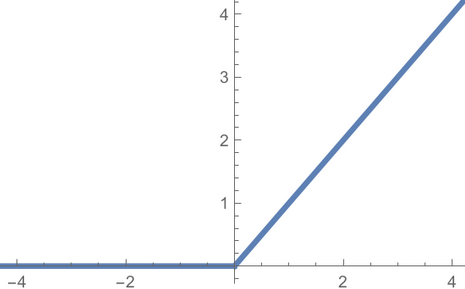

<br>
Para a função relu, se o valor produzido por um neurônio for negativo, ele será automaticamente 0, caso for positivo, ele será transformado e considerado.

<br>
<br>
**Verificar tirar isso**
<br>
Uma camada Dropout - com 10% de chance de ativação
<br>
<br>
Uma camada dense - com uma função de ativação linear
<br>
<br>
**Continuar:**

<br>
<br>


**Otimizador** - O otimizador é um algorítimo usado para modificar os atributos de uma rede neural a cada época de treinamento com o intutio de reduzir o erro produzido pela rede neural a cada época. 
<br>
Exemplo: a cada época de treinamento, a rede passa por um ajuste nos pesos de seus neurônios para que no próximo treinamento o erro seja cada vez menor, e este ajuste nos pesos é realizado por conta do otimizador.
<br>
O otimizador utilizado foi o **Adam**.
<br>
<br>
**Observação:**
<br>
-* **Overfitting** - Um modelo que se ajustou tão bem a base utilizada para o treinamento, que quando ele é exposto a outra amostra de dados (amostra de validação por exemplo), ele não apresenta uma previsão tão boa (pois o erro para a amostra de validação começa a ficar grande). Desta maneira, um modelo que apresenta overffiting é um modelo que perde a capacidade de generalização, realizando previsões tão boas para a base de treino, mas quando ele é exposto a uma outra base de dados, o erro da previsão (diferença entre o valor real e o valor previsto) é muito grande. 

## Modelo 1:

### Criação da rede neural - Modelo 1:

In [ ]:
modelo_1 = Sequential()

# Adicionar a primeira camada LSTM
modelo_1.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train_1.shape[1], 1)))

# Adicionar camada Dropout Aumetar para 0,5
modelo_1.add(Dropout(0.2))

# Adiconar camda Flatten =>(Colocar no final e ver o que acontece)
modelo_1.add(Flatten())

# Adicionar camada Dense
modelo_1.add(Dense(100, activation='relu'))

# Adicionar camada Dropout =>(retirar essa camada e ver o que acontece)
modelo_1.add(Dropout(0.1))

# Adicionar Camda Dense =>(retirar essa camada e ver o que acontece pode ser redundante)
modelo_1.add(Dense(1)) 


model_checkpoint = ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = Adam(lr=6e-3, amsgrad=True)

modelo_1.compile(loss=MeanSquaredError(),
                          optimizer=optimizer,
                          metrics=RootMeanSquaredError())

# Visualizar a rede
modelo_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               160100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 201,001
Trainable params: 201,001
Non-trainable params: 0
________________________________________________

### Treinamento do Modelo 1:
Realizar o treinamento da rede neural do Modelo 1 utilziando as bases de treino e validação (para a realização do **"cross validation"** durante o treinmento da rede neural.

In [ ]:
history_modelo_1 = modelo_1.fit(X_train_1, Y_train_1, epochs=150,validation_data=(X_val_1,Y_val_1),callbacks=[EarlyStopping(patience=50), model_checkpoint])

Epoch 1/150
614/614 [==============================] - 36s 5ms/step - loss: 276.2645 - root_mean_squared_error: 15.6789 - val_loss: 49.2203 - val_root_mean_squared_error: 7.0157
Epoch 2/150
614/614 [==============================] - 3s 4ms/step - loss: 130.0078 - root_mean_squared_error: 11.3995 - val_loss: 108.3669 - val_root_mean_squared_error: 10.4099
Epoch 3/150
614/614 [==============================] - 3s 4ms/step - loss: 116.6912 - root_mean_squared_error: 10.8018 - val_loss: 55.2100 - val_root_mean_squared_error: 7.4303
Epoch 4/150
614/614 [==============================] - 3s 4ms/step - loss: 116.7405 - root_mean_squared_error: 10.8035 - val_loss: 91.9509 - val_root_mean_squared_error: 9.5891
Epoch 5/150
614/614 [==============================] - 3s 4ms/step - loss: 113.7906 - root_mean_squared_error: 10.6665 - val_loss: 71.0972 - val_root_mean_squared_error: 8.4319
Epoch 6/150
614/614 [==============================] - 3s 4ms/step - loss: 115.9204 - root_mean_squared_error: 1

### Avaliação do treinamento:
Será observado o gráfico dos erros da amostra de treino (**"Training loss"**) e os erros da amostra utilizada na **"cross validation"** (**"validation loss"**) para determinar se o modelo apresentou overfitting ou não.
<br>
<br>
O que precisa ser analisado neste gráfico é observar se durante o término do treinamento:
<br>
<br>
1 - Os valores de **"Training loss"** e **"validation loss"** estarem caidno a medida que o número de épocas do treinamento aumentam.
<br>
<br>
2 - O treinamento não pode ser concluído com os valores de: **validation loss** > **Training loss** pois isto indicaria um **Overfitting** do modelo.

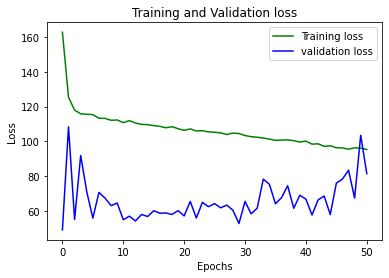

In [ ]:
loss_train = history_modelo_1.history['loss']
loss_val = history_modelo_1.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Observação**:
<br>
Ao observar o gráfico acima, que mostra o erro da amostra de teste (**“Training loss”**) e da amostra de validação (**“validation loss”**), constata-se que: a medida que o número de épocas aumenta, o erro da amostra de treino cai, porém, o erro da amostra de validação aumenta até um ponto em que as retas se cruzam e depis o erro da amostra de validação cai novamente. Este comportamento não apredentou indícios de overfitting do modelo pois o treinamento da rede não concluiu com o valor de **validation loss** > **Training loss**.
<br>
<br>
Por outro lado, este modelo ainda necessida de ajustes, pois o ideal seria um modelo onde os erros tanto para a amostra de treino quanto para a amostra de validação fiquem baixos e que o reinamento não conclua com os valores de **validation loss** > **Training loss**.
<br>
<br>
Desta maeneira, uma forma de melhorar este modelo seria diminuir o número de treinamento para um valor entre 30 ou 40 épocas. Porém, será realizado o treinamento dos demais modelos (Modelo 2 - com 10 varipaveis e Modelo 3 - com 6 variáveis), para verificar se uma redução na complexidade do modelo, isto é, uma dininuição no número de variáveis preditivas do modelo é suficiente para melhorar a capacidade preditiva da rede neural.

### Realizar a previsão
Realizar a previsão do Modelo 1 utilizando a base de teste

In [ ]:
previsao_1 = modelo_1.predict(X_test_1)
previsao_1

array([[58.338604],
       [56.803017],
       [53.573227],
       ...,
       [73.07662 ],
       [69.82132 ],
       [69.46548 ]], dtype=float32)

#### Verificar a previsão do Modelo 1 em um gráfico para as últimas 250 horas:

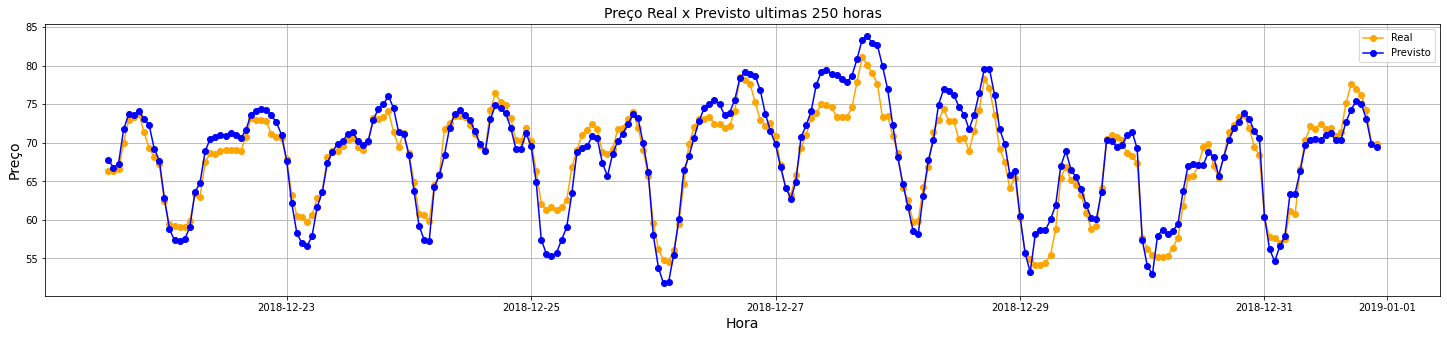

In [ ]:
# Criando um dataframe com os resultados previstos
previsao_1 =  pd.DataFrame(previsao_1,
                                 columns=["price_previsto"])

# Resentando o indice da colua "price actual" da variável de treino
resposta_treino = df_variavel_alvo_teste_modelo_1.reset_index()
resposta_treino.rename(columns = {'index': 'time'}, inplace = True)

# Juntando os dataframes para criar visualização de comparação de respostas:
df_comparacao = previsao_1.merge(resposta_treino, left_index=True, right_index=True)

df_visual = df_comparacao.tail(250)

fig = plt.figure(figsize=(25, 5))

#plt.subplot(2, 1, 1)
plt.plot(df_visual['time'],df_visual['price actual'], color='orange', marker='o', label='Real')
plt.title('Preço Real 50 ultimos dias)', fontsize=14)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Preço', fontsize=14)
plt.grid(True)


#plt.subplot(2, 1, 2)
plt.plot(df_visual['time'],df_visual['price_previsto'], color='blue', marker='o', label='Previsto')
plt.title('Preço Real x Previsto ultimas 250 horas', fontsize=14)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Preço', fontsize=14)
plt.grid(True)

plt.xlabel('Hora')
plt.ylabel('Preço')
plt.legend(["Real","Previsto"])

plt.show()

### Métricas de Avaliação:

#### RMSE:
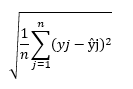

<br>
Onde:
<br>
yj = valor real
<br>
ŷj = valor previsto
 <br>
n = número de observações
 <br>
 <br>
 Calcula a raiz quadrada da diferença dos erros residuais (yj -   ŷj) elevado ao quadrado dividido pelo número de observações (n)
 <br>
 <br>
 Quanto mais próximo de 0 melhor.

In [ ]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(df_variavel_alvo_teste_modelo_1, previsao_1))
print('RMSE: ', rmse)

RMSE:  9.901494591888746


#### MAPE:
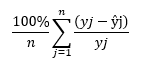

<br>

Onde:
<br>
yj = valor real
<br>
ŷj = valor previsto
 <br>
n = número de observações
<br>
<br>
Calcula o somatório da diferença dos erros residuais (yj - ŷj) dividido pelo valor real (y) sobre o número de observações (n). 
<br>
<br>
Observação: O valor foi multiplicado po 100% para obter o percentual
<br>
Quanto mais próximo de 0%, melhor.

In [ ]:
mape_real_1 = df_variavel_alvo_teste_modelo_1
mape_real_1 = mape_real_1.reset_index(drop=True).to_numpy()
mape_previsto_1 = previsao_1.to_numpy()

print('MAPE:', np.mean(np.abs((mape_real_1 - mape_previsto_1) / mape_real_1)) * 100,'%')

MAPE: 12.314311752707638 %


## Modelo 2:

### Criação da rede neural - Modelo 2:

In [ ]:
modelo_2 = Sequential()

# Adicionar a primeira camada LSTM
modelo_2.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train_2.shape[1], 1)))

# Adicionar camada Dropout
modelo_2.add(Dropout(0.2))

# Adiconar camda Flatten
modelo_2.add(Flatten())

# Adicionar camada Dense
modelo_2.add(Dense(100, activation='relu'))

# Adicionar camada Dropout
modelo_2.add(Dropout(0.1))

# Adicionar Camda Dense
modelo_2.add(Dense(1)) 


model_checkpoint = ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = Adam(lr=6e-3, amsgrad=True)

modelo_2.compile(loss=MeanSquaredError(),
                          optimizer=optimizer,
                          metrics=RootMeanSquaredError())

# Visualizar a rede
modelo_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 10, 100)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 141,001
Trainable params: 141,001
Non-trainable params: 0
__________________________________________________

### Treinamento do Modelo 2:
Realizar o treinamento da rede neural do Modelo 2 utilziando as bases de treino e validação (para a realização do **"cross validation"** durante o treinmento da rede neural.

In [ ]:
history_modelo_2 = modelo_2.fit(X_train_2, Y_train_2, epochs=150,validation_data=(X_val_2,Y_val_2),callbacks=[EarlyStopping(patience=50), model_checkpoint])

Epoch 1/150
614/614 [==============================] - 36s 5ms/step - loss: 284.6817 - root_mean_squared_error: 15.8880 - val_loss: 50.6018 - val_root_mean_squared_error: 7.1135
Epoch 2/150
614/614 [==============================] - 3s 4ms/step - loss: 125.0377 - root_mean_squared_error: 11.1815 - val_loss: 59.0063 - val_root_mean_squared_error: 7.6816
Epoch 3/150
614/614 [==============================] - 3s 4ms/step - loss: 120.8193 - root_mean_squared_error: 10.9907 - val_loss: 64.7037 - val_root_mean_squared_error: 8.0439
Epoch 4/150
614/614 [==============================] - 3s 4ms/step - loss: 120.0111 - root_mean_squared_error: 10.9533 - val_loss: 70.3055 - val_root_mean_squared_error: 8.3848
Epoch 5/150
614/614 [==============================] - 3s 4ms/step - loss: 120.1176 - root_mean_squared_error: 10.9576 - val_loss: 106.5775 - val_root_mean_squared_error: 10.3236
Epoch 6/150
614/614 [==============================] - 3s 4ms/step - loss: 116.3435 - root_mean_squared_error: 1

### Avaliação do treinamento:
Conforme já mencionado anteriormente, será observado o gráfico dos erros da amostra de treino (**"Training loss"**) e os erros da amostra utilizada na **"cross validation"** (**"validation loss"**)
<br>
<br>
O que precisa ser analisado neste gráfico é observar se durante o término do treinamento:
<br>
<br>
1 - Os valores de **"Training loss"** e **"validation loss"** estarem caidno a medida que o número de épocas do treinamento aumentam.
<br>
<br>
2 - O treinamento não pode ser concluído com os valores de: **validation loss** > **Training loss** pois isto indicaria um **Overfitting** do modelo.
 

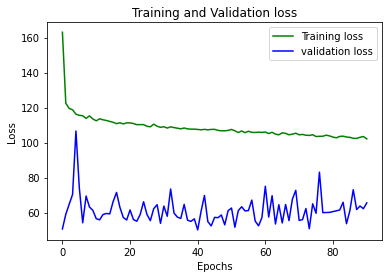

In [ ]:
loss_train = history_modelo_2.history['loss']
loss_val = history_modelo_2.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Observação**:
<br>
O Modelo 2 concluíu o treinamento com os valores de **validation loss** < **Training loss** não apresentando indícios de overfitting.
<br>
<br>
Ao comparar com o Modelo 1, o treinamento concluí com o valor de **validation loss** muito abaixo do valor de **Training loss**, o que poderia indicar que com uma redução na complexidade do modelo (uma dininuição no número de variáveis preditivas do modelo) apresentou uma melhora no treinamento da rede neural, indicando que o Modelo 2 poderia apresentar uma capacidade de generalização melhor do que o Modelo 1. Mas vara avaliar isto, será necessário avaliar as métricas de avaliação entre os dois modelos.

### Realizar a previsão
Realizar a previsão do Modelo 2 utilizando a base de teste

In [ ]:
previsao_2 = modelo_2.predict(X_test_2)
previsao_2

array([[58.369156],
       [54.543964],
       [53.728653],
       ...,
       [73.95422 ],
       [72.041565],
       [71.9901  ]], dtype=float32)

#### Verificar a previsão do Modelo 2 em um gráfico para as últimas 250 horas:

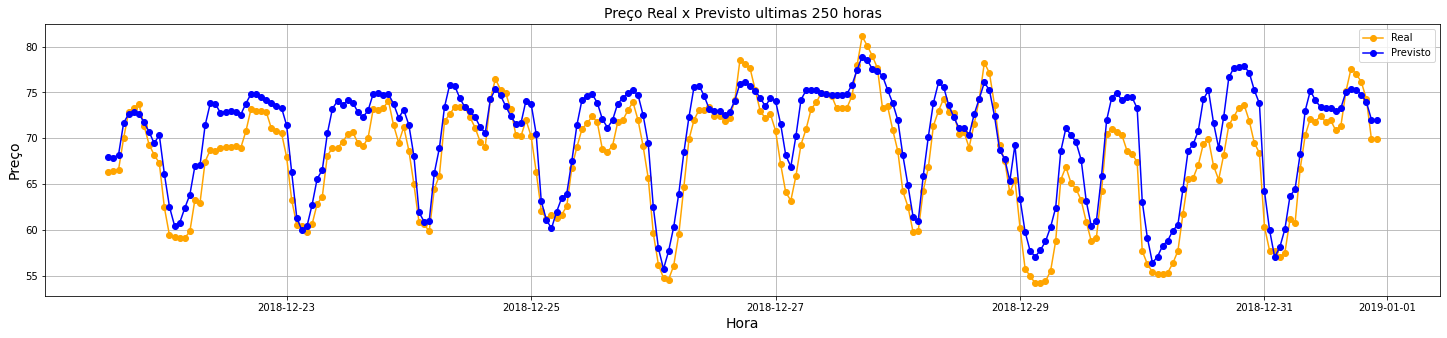

In [ ]:
# Criando um dataframe com os resultados previstos
previsao_2 =  pd.DataFrame(previsao_2,
                                 columns=["price_previsto"])

# Resentando o indice da colua "price actual" da variável de treino
resposta_treino = df_variavel_alvo_teste_modelo_2.reset_index()
resposta_treino.rename(columns = {'index': 'time'}, inplace = True)

# Juntando os dataframes para criar visualização de comparação de respostas:
df_comparacao = previsao_2.merge(resposta_treino, left_index=True, right_index=True)

df_visual = df_comparacao.tail(250)

fig = plt.figure(figsize=(25, 5))

#plt.subplot(2, 1, 1)
plt.plot(df_visual['time'],df_visual['price actual'], color='orange', marker='o', label='Real')
plt.title('Preço Real 50 ultimos dias)', fontsize=14)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Preço', fontsize=14)
plt.grid(True)


#plt.subplot(2, 1, 2)
plt.plot(df_visual['time'],df_visual['price_previsto'], color='blue', marker='o', label='Previsto')
plt.title('Preço Real x Previsto ultimas 250 horas', fontsize=14)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Preço', fontsize=14)
plt.grid(True)

plt.xlabel('Hora')
plt.ylabel('Preço')
plt.legend(["Real","Previsto"])

plt.show()

### Métricas de Avaliação:

#### RMSE:
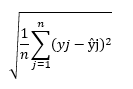

<br>
Onde:
<br>
yj = valor real
<br>
ŷj = valor previsto
 <br>
n = número de observações
 <br>
 <br>
 Calcula a raiz quadrada da diferença dos erros residuais (yj -   ŷj) elevado ao quadrado dividido pelo número de observações (n)
 <br>
 <br>
 Quanto mais próximo de 0 melhor.

In [ ]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(df_variavel_alvo_teste_modelo_2, previsao_2))
print('RMSE: ', rmse)

RMSE:  9.820041308344312


#### MAPE:
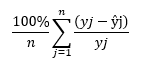

<br>

Onde:
<br>
yj = valor real
<br>
ŷj = valor previsto
 <br>
n = número de observações
<br>
<br>
Calcula o somatório da diferença dos erros residuais (yj - ŷj) dividido pelo valor real (y) sobre o número de observações (n). 
<br>
<br>
Observação: O valor foi multiplicado po 100% para obter o percentual
<br>
Quanto mais próximo de 0%, melhor.

In [ ]:
mape_real_2 = df_variavel_alvo_teste_modelo_2
mape_real_2 = mape_real_2.reset_index(drop=True).to_numpy()
mape_previsto_2 = previsao_2.to_numpy()

print('MAPE:', np.mean(np.abs((mape_real_2 - mape_previsto_2) / mape_real_2)) * 100,'%')

MAPE: 12.784638574601528 %


#### Observação:
Ao avaliar as méticas acima, uma redução das variáveis preditivas utilziadas no modelo não apresentaram uma melhora significativa da capacidade preditiva do modelo. Por outro ládo, o medelo conseguiu realizar uma previsão com 10 variáveis tão boa quanto utilizando 16 variáveis.

# Modelo 3

### Criação da rede neural - Modelo 3:

In [ ]:
modelo_3 = Sequential()

# Adicionar a primeira camada LSTM
modelo_3.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train_3.shape[1], 1)))

# Adicionar camada Dropout
modelo_3.add(Dropout(0.2))

# Adiconar camda Flatten
modelo_3.add(Flatten())

# Adicionar camada Dense
modelo_3.add(Dense(100, activation='relu'))

# Adicionar camada Dropout
modelo_3.add(Dropout(0.1))

# Adicionar Camda Dense
modelo_3.add(Dense(1)) 


model_checkpoint = ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = Adam(lr=6e-3, amsgrad=True)

modelo_3.compile(loss=MeanSquaredError(),
                          optimizer=optimizer,
                          metrics=RootMeanSquaredError())

# Visualizar a rede
modelo_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 100)            40800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 100)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               60100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 101,001
Trainable params: 101,001
Non-trainable params: 0
________________________________________________

### Treinamento do Modelo 3:
Realizar o treinamento da rede neural do Modelo 3 utilziando as bases de treino e validação (para a realização do **"cross validation"** durante o treinmento da rede neural.

In [ ]:
history_modelo_3 = modelo_3.fit(X_train_3, Y_train_3, epochs=150,validation_data=(X_val_3,Y_val_3),callbacks=[EarlyStopping(patience=50), model_checkpoint])

Epoch 1/150
614/614 [==============================] - 4s 4ms/step - loss: 319.9404 - root_mean_squared_error: 16.5936 - val_loss: 63.8482 - val_root_mean_squared_error: 7.9905
Epoch 2/150
614/614 [==============================] - 2s 4ms/step - loss: 125.3048 - root_mean_squared_error: 11.1926 - val_loss: 52.7182 - val_root_mean_squared_error: 7.2607
Epoch 3/150
614/614 [==============================] - 2s 4ms/step - loss: 123.7313 - root_mean_squared_error: 11.1224 - val_loss: 54.7345 - val_root_mean_squared_error: 7.3983
Epoch 4/150
614/614 [==============================] - 2s 4ms/step - loss: 121.3843 - root_mean_squared_error: 11.0153 - val_loss: 61.8568 - val_root_mean_squared_error: 7.8649
Epoch 5/150
614/614 [==============================] - 2s 4ms/step - loss: 116.2155 - root_mean_squared_error: 10.7783 - val_loss: 60.1867 - val_root_mean_squared_error: 7.7580
Epoch 6/150
614/614 [==============================] - 2s 4ms/step - loss: 118.0289 - root_mean_squared_error: 10.8

### Avaliação do treinamento:
Conforme já mencionado anteriormente, será observado o gráfico dos erros da amostra de treino (**"Training loss"**) e os erros da amostra utilizada na **"cross validation"** (**"validation loss"**)
<br>
<br>
O que precisa ser analisado neste gráfico é observar se durante o término do treinamento:
<br>
<br>
1 - Os valores de **"Training loss"** e **"validation loss"** estarem caidno a medida que o número de épocas do treinamento aumentam.
<br>
<br>
2 - O treinamento não pode ser concluído com os valores de: **validation loss** > **Training loss** pois isto indicaria um **Overfitting** do modelo.

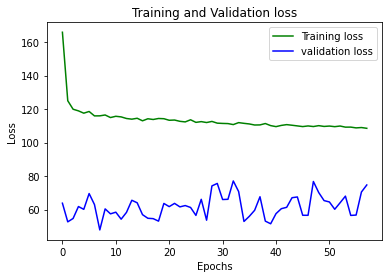

In [ ]:
loss_train = history_modelo_3.history['loss']
loss_val = history_modelo_3.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Observação**:
<br>
O Modelo 3 concluíu o treinamento com os valores de **validation loss** < **Training loss** não apresentando indícios de overfitting.

### Realizar a previsão
Realizar a previsão do Modelo 3 utilizando a base de teste

In [ ]:
previsao_3 = modelo_3.predict(X_test_3)
previsao_3

array([[61.903538],
       [58.23996 ],
       [55.533947],
       ...,
       [73.96066 ],
       [71.49753 ],
       [71.0866  ]], dtype=float32)

#### Verificar a previsão do Modelo 3 em um gráfico para as últimas 250 horas:

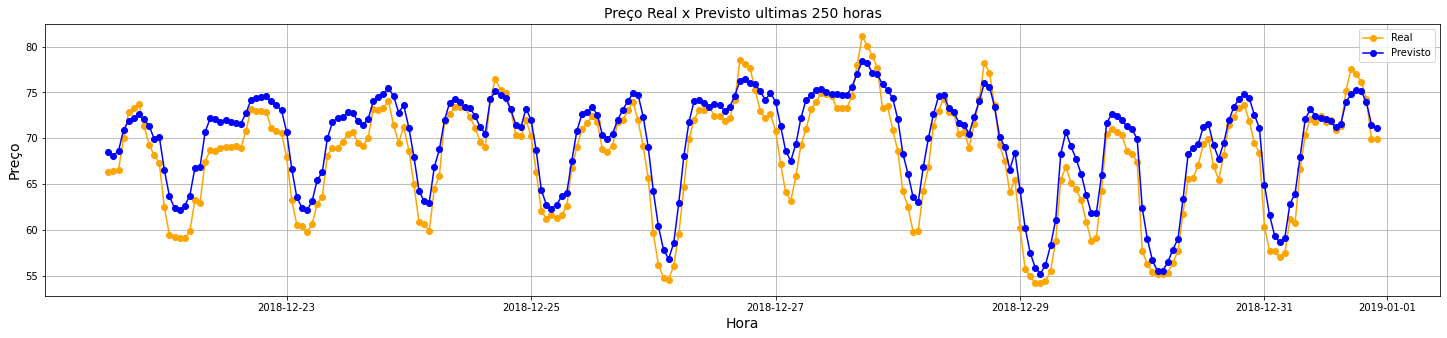

In [ ]:
# Criando um dataframe com os resultados previstos
previsao_3 =  pd.DataFrame(previsao_3,
                                 columns=["price_previsto"])

# Resentando o indice da colua "price actual" da variável de treino
resposta_treino = df_variavel_alvo_teste_modelo_3.reset_index()
resposta_treino.rename(columns = {'index': 'time'}, inplace = True)

# Juntando os dataframes para criar visualização de comparação de respostas:
df_comparacao = previsao_3.merge(resposta_treino, left_index=True, right_index=True)

df_visual = df_comparacao.tail(250)

fig = plt.figure(figsize=(25, 5))

#plt.subplot(2, 1, 1)
plt.plot(df_visual['time'],df_visual['price actual'], color='orange', marker='o', label='Real')
plt.title('Preço Real 50 ultimos dias)', fontsize=14)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Preço', fontsize=14)
plt.grid(True)


#plt.subplot(2, 1, 2)
plt.plot(df_visual['time'],df_visual['price_previsto'], color='blue', marker='o', label='Previsto')
plt.title('Preço Real x Previsto ultimas 250 horas', fontsize=14)
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Preço', fontsize=14)
plt.grid(True)

plt.xlabel('Hora')
plt.ylabel('Preço')
plt.legend(["Real","Previsto"])

plt.show()

### Métricas de Avaliação:

#### RMSE:
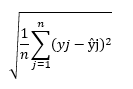

<br>
Onde:
<br>
yj = valor real
<br>
ŷj = valor previsto
 <br>
n = número de observações
 <br>
 <br>
 Calcula a raiz quadrada da diferença dos erros residuais (yj -   ŷj) elevado ao quadrado dividido pelo número de observações (n)
 <br>
 <br>
 Quanto mais próximo de 0 melhor.

In [ ]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(df_variavel_alvo_teste_modelo_3, previsao_3))
print('RMSE: ', rmse)

RMSE:  9.768239115749088


#### MAPE:
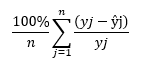

<br>

Onde:
<br>
yj = valor real
<br>
ŷj = valor previsto
 <br>
n = número de observações
<br>
<br>
Calcula o somatório da diferença dos erros residuais (yj - ŷj) dividido pelo valor real (y) sobre o número de observações (n). 
<br>
<br>
Observação: O valor foi multiplicado po 100% para obter o percentual
<br>
Quanto mais próximo de 0%, melhor.

In [ ]:
mape_real_3 = df_variavel_alvo_teste_modelo_3
mape_real_3 = mape_real_3.reset_index(drop=True).to_numpy()
mape_previsto_3 = previsao_3.to_numpy()

print('MAPE:', np.mean(np.abs((mape_real_3 - mape_previsto_3) / mape_real_3)) * 100,'%')

MAPE: 11.71017820091246 %


# Considerações finais:
O Modelo 3, utilizando o janelamento da variável **"price day ahead"** cinco horas para traz apresnetou um melhor resultado do que os outros dois modelos anteriores.
<br>
<br>
Desta maneira, a realização do janelamento da variável **"price day ahead"** foi suficiente para a criação de uma rede neural capaz de realizar a previsão do preço da energia.